<h1 style="text-align:center;"><b>Laboratorio 1</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

In [183]:
import sys
!{sys.executable} -m pip install --user 'pmdarima'

  Using cached pmdarima-2.0.4.tar.gz (630 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pmdarima (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      Partial import of pmdarima during the build process.
      Requirements: ['joblib>=0.11', 'Cython>=0.29,!=0.29.18,!=0.29.31', 'numpy>=1.21.2', 'pandas>=0.19', 'scikit-learn>=0.22', 'scipy>=1.3.2', 'statsmodels>=0.13.2', 'urllib3', 'setuptools>=38.6.0,!=50.0.0', 'packaging>=17.1  # Bundled with setuptools, but want to be explicit']
      Adding extra setuptools args
      Setting up with setuptools
      Traceback (most recent call last):
        File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
          ~~~~^^
    

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Importar datos

In [2]:
#CONSUMO

archivo = 'Datos/Consumo.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
consumo = df[columnas_deseadas]
print('\nDatos filtrados:')
consumo.head()


Datos filtrados:


Gasolina superior  Gasolina regular  Diesel alto azufre
Fecha                                                              
2000-01-01          308156.82         202645.20           634667.06
2000-02-01          307766.31         205530.96           642380.66
2000-03-01          331910.29         229499.56           699807.25
2000-04-01          315648.08         210680.40           586803.98
2000-05-01          319667.97         208164.34           656948.20

In [3]:
#IMPORTACIONES

archivo = 'Datos/Importaciones.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
importaciones = df[columnas_deseadas]
print('\nDatos filtrados:')
importaciones.head()


Datos filtrados:


Gasolina superior  Gasolina regular  Diesel alto azufre
Fecha                                                              
2001-01-01          373963.96         177776.50           566101.99
2001-02-01          243091.07         123115.99           489525.80
2001-03-01          312084.38         161726.42           575559.68
2001-04-01          285054.89         127338.74           437745.42
2001-05-01          300913.67         168730.19           552609.13

## Convertir en series de tiempo

In [4]:
#Gasolina superior
ts_consumo_superior = consumo['Gasolina superior']
ts_importa_superior = importaciones['Gasolina superior']

#Gasolina regular
ts_consumo_regular = consumo['Gasolina regular']
ts_importa_regular = importaciones['Gasolina regular']

#Diesel alto azufre
ts_consumo_diesel = consumo['Diesel alto azufre']
ts_importa_diesel = importaciones['Diesel alto azufre']

## Análisis exploratorio

In [5]:
print("Consumo")
print(ts_consumo_superior.describe(),ts_consumo_regular.describe(),ts_consumo_diesel.describe())

print("\nImportaciones")
print( ts_importa_superior.describe(),  ts_importa_regular.describe(),  ts_importa_diesel.describe())

Consumo
count       300.000000
mean     470248.678849
std      113504.653305
min      300242.781667
25%      383931.904375
50%      423319.540000
75%      573704.195000
max      786598.120000
Name: Gasolina superior, dtype: float64 count       300.000000
mean     397478.894458
std      219102.049432
min      160741.900000
25%      215650.312917
50%      288193.130000
75%      548073.682500
max      938086.570000
Name: Gasolina regular, dtype: float64 count    3.000000e+02
mean     5.144313e+05
std      3.688977e+05
min      0.000000e+00
25%      0.000000e+00
50%      6.721700e+05
75%      7.791021e+05
max      1.149175e+06
Name: Diesel alto azufre, dtype: float64

Importaciones
count    2.880000e+02
mean     4.909544e+05
std      1.565581e+05
min      1.702925e+05
25%      3.693299e+05
50%      4.813002e+05
75%      6.083053e+05
max      1.227174e+06
Name: Gasolina superior, dtype: float64 count    2.880000e+02
mean     4.129493e+05
std      2.432627e+05
min      8.101530e+04
25%      

Se puede ver que la gasolina Diesel tiene la media de consumo más alta (735 000), casi el doble de la media de consumo de la gasolina superior (420 000). A su vez, la gasolina superior tiene una media de consumo de casi el doble de la media de la gasolina regular (270 000). La desviación estándar coincide en las diferencias (es decir, el diesel tiene la desviación más grande, seguido de superior y por último regular). 

En cuanto a las importaciones, se mantiene el orden. Se puede ver que la gasolina tiene uan media de importación de alrededor de 800 000, mientras que la gasdolina superior tiene una de alrededor de 430 000. El promedio de importaciones de la gaslolina regular es de alrededor 280 000. 

Se puede observar que el valor de la media consumo medio es alrededor de 10 000 menor que las importaciones.

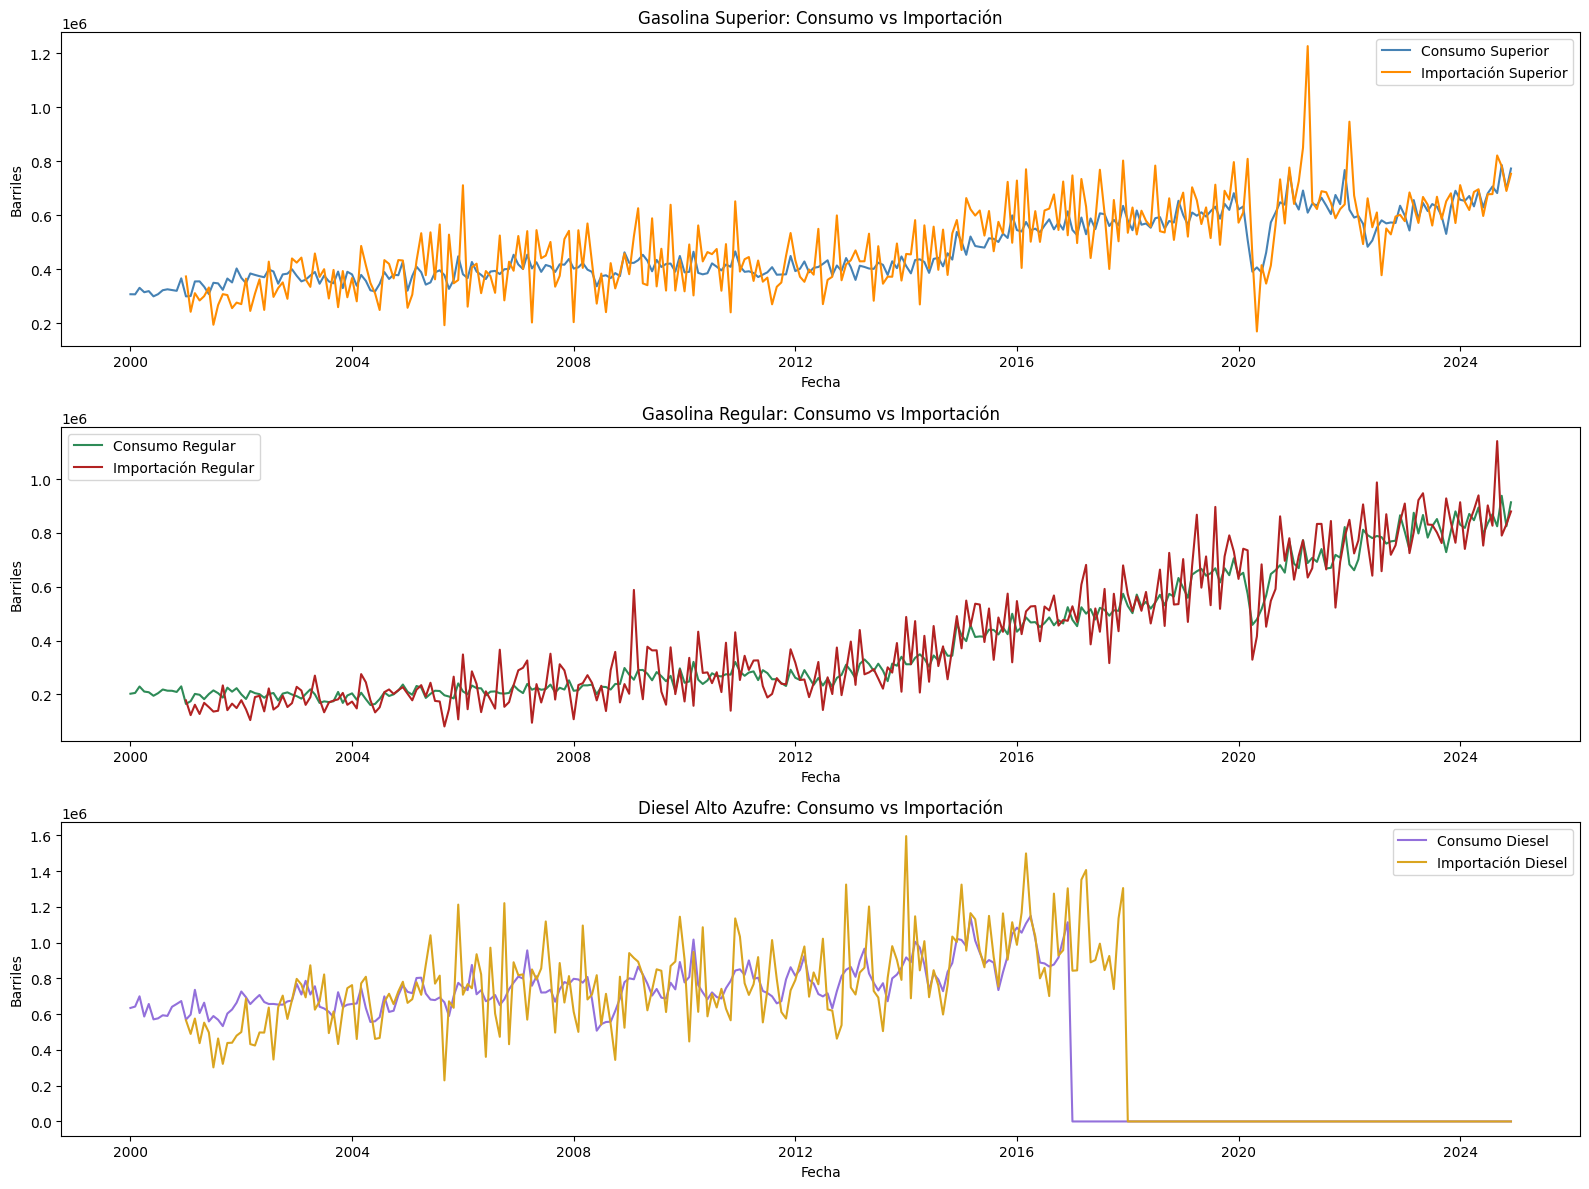

In [6]:
#Gasolina Superior
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(ts_consumo_superior, label='Consumo Superior', color='steelblue')
plt.plot(ts_importa_superior, label='Importación Superior', color='darkorange')
plt.title('Gasolina Superior: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Gasolina Regular
plt.subplot(3, 1, 2)
plt.plot(ts_consumo_regular, label='Consumo Regular', color='seagreen')
plt.plot(ts_importa_regular, label='Importación Regular', color='firebrick')
plt.title('Gasolina Regular: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Diesel Alto Azufre
plt.subplot(3, 1, 3)
plt.plot(ts_consumo_diesel, label='Consumo Diesel', color='mediumpurple')
plt.plot(ts_importa_diesel, label='Importación Diesel', color='goldenrod')
plt.title('Diesel Alto Azufre: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()
plt.tight_layout()
plt.show()

### Análisis de normalidad

In [7]:
from scipy.stats import shapiro
stat1, p1 = shapiro(ts_consumo_superior)
stat2, p2 = shapiro(ts_importa_superior)
stat3, p3 = shapiro(ts_consumo_regular)
stat4, p4 = shapiro(ts_importa_regular)
stat5, p5 = shapiro(ts_consumo_diesel)
stat6, p6 = shapiro(ts_importa_diesel)

print(p1, p2, p3, p4, p5, p6)

3.506804326490063e-12 3.9058785496496804e-05 1.140071930723717e-16 1.6854999268180919e-12 9.372158444314666e-19 5.238734057074212e-13


El valor-p es menor a 0.05 para todas las variables, lo que indica que todas estan distribuidas normalmente

### Meses en los que más importaciones hay

In [8]:
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

promedio_consumo_superior = ts_consumo_superior.groupby(ts_consumo_superior.index.month).mean()
promedio_consumo_superior.index = meses
print('Consumo\n')
print(promedio_consumo_superior)

promedio_consumo_regular = ts_consumo_regular.groupby(ts_consumo_regular.index.month).mean()
promedio_consumo_regular.index = meses
print(promedio_consumo_regular)

promedio_consumo_diesel = ts_consumo_diesel.groupby(ts_consumo_diesel.index.month).mean()
promedio_consumo_diesel.index = meses
print(promedio_consumo_diesel)

print('\nImportaciones')

promedio_importa_superior = ts_importa_superior.groupby(ts_importa_superior.index.month).mean()
promedio_importa_superior.index = meses
print(promedio_importa_superior)

promedio_importa_regular = ts_importa_regular.groupby(ts_importa_regular.index.month).mean()
promedio_importa_regular.index = meses
print(promedio_importa_regular)

promedio_importa_diesel = ts_importa_diesel.groupby(ts_importa_diesel.index.month).mean()
promedio_importa_diesel.index = meses
print(promedio_importa_diesel)

Consumo

Enero         465444.133900
Febrero       449589.379500
Marzo         485997.725420
Abril         454148.854300
Mayo          455444.417900
Junio         437856.819500
Julio         471367.123900
Agosto        478979.751100
Septiembre    456616.414433
Octubre       481344.612300
Noviembre     469803.929900
Diciembre     536390.984033
Name: Gasolina superior, dtype: float64
Enero         383185.687333
Febrero       369956.867333
Marzo         411988.348533
Abril         394359.671433
Mayo          393026.630933
Junio         378066.094133
Julio         398433.337333
Agosto        402503.807333
Septiembre    385355.633152
Octubre       405274.873333
Noviembre     394711.527933
Diciembre     452884.254705
Name: Gasolina regular, dtype: float64
Enero         542594.861848
Febrero       534185.231238
Marzo         595864.636895
Abril         543003.669910
Mayo          520845.624667
Junio         467567.321829
Julio         475682.383192
Agosto        478067.624152
Septiembre    44

Se puede observar que aunque el cambio no es tan signficativo si existen diferencias por mes. Por ejemplo, el consumo de gasolina sin importar el tipo es mas alto en diciembre y bajo en febrero. Para las importaciones el diesel tiene un valor mucho mas alto en diciembre, pero los demas tipos no demuestran tanta diferencia.

## Train y Test

In [164]:
#Consumo
train_size_C = int(len(consumo) * 0.7)
train_c = consumo[0:train_size_C]
test_c = consumo[train_size_C:len(consumo)]

#Importaciones
train_size_I = int(len(importaciones) * 0.7)
train_i = importaciones[0:train_size_I]
test_i = importaciones[train_size_I:len(importaciones)]

### <span style="color: blue;">Análisis Preliminar Gasolina Superior</span>

In [139]:
#Consumo
ts_consumo_superior = train_c['Gasolina superior']
ts_consumo_superior_test = test_c['Gasolina superior']

print('Consumo Gasolina Superior')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie:',ts_consumo_superior.head(1))
print('\nFin de la serie:',ts_consumo_superior.tail(1))


#Importaciones
ts_importa_superior = train_i['Gasolina superior']
ts_importa_superior_test = test_i['Gasolina superior']

print('\nImportaciones Gasolina Superior')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_importa_superior.head(1))
print('\nFin de la serie', ts_importa_superior.tail(1))



Consumo Gasolina Superior
Frecuencia: MENSUAL

Inicio de la serie: Fecha
2000-01-01    308156.82
Name: Gasolina superior, dtype: float64

Fin de la serie: Fecha
2017-06-01    549378.05
Name: Gasolina superior, dtype: float64

Importaciones Gasolina Superior
Frecuencia: MENSUAL

Inicio de la serie Fecha
2001-01-01    373963.96
Name: Gasolina superior, dtype: float64

Fin de la serie Fecha
2017-09-01    401678.98
Name: Gasolina superior, dtype: float64


### <span style="color: blue;">Análisis preliminar Diesel Azufre Alto</span>

In [140]:
#Consumo
ts_consumo_diesel = train_c['Diesel alto azufre']
ts_consumo_diesel_test = test_c['Diesel alto azufre']

print('Consumo Gasolina Diesel Alto Azufre')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie:',ts_consumo_diesel.head(1))
print('\nFin de la serie:',ts_consumo_diesel.tail(1))

#Impotaciones
ts_importa_diesel = train_i['Diesel alto azufre']
ts_importa_diesel_test = test_i['Diesel alto azufre']


print('\nImportaciones Gasolina Diesel Alto Azufre')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_importa_diesel.head(1))
print('\nFin de la serie', ts_importa_diesel.tail(1))


Consumo Gasolina Diesel Alto Azufre
Frecuencia: MENSUAL

Inicio de la serie: Fecha
2000-01-01    634667.06
Name: Diesel alto azufre, dtype: float64

Fin de la serie: Fecha
2017-06-01    0.0
Name: Diesel alto azufre, dtype: float64

Importaciones Gasolina Diesel Alto Azufre
Frecuencia: MENSUAL

Inicio de la serie Fecha
2001-01-01    566101.99
Name: Diesel alto azufre, dtype: float64

Fin de la serie Fecha
2017-09-01    925397.87
Name: Diesel alto azufre, dtype: float64


### <span style="color: blue;">Análisis preliminar Gasolina Regular</span>

In [12]:
#Consumo
ts_consumo_regular = train_c['Gasolina regular']
ts_consumo_regular_test = test_c['Gasolina regular']

print('Consumo Gasolina Regular')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie:',ts_consumo_regular.head(1))
print('\nFin de la serie:',ts_consumo_regular.tail(1))

#Impotaciones
ts_importa_regular = train_i['Gasolina regular']
ts_importa_regular_test = test_i['Gasolina regular']

print('\nImportaciones Gasolina Regular')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_importa_regular.head(1))
print('\nFin de la serie', ts_importa_regular.tail(1))

Consumo Gasolina Regular
Frecuencia: MENSUAL

Inicio de la serie: Fecha
2000-01-01    202645.2
Name: Gasolina regular, dtype: float64

Fin de la serie: Fecha
2017-06-01    478491.95
Name: Gasolina regular, dtype: float64

Importaciones Gasolina Regular
Frecuencia: MENSUAL

Inicio de la serie Fecha
2001-01-01    177776.5
Name: Gasolina regular, dtype: float64

Fin de la serie Fecha
2017-09-01    316435.22
Name: Gasolina regular, dtype: float64


## Series de Tiempo

### <span style="color: blue;">1. Consumo Gasolina Superior</span>

#### Exploración

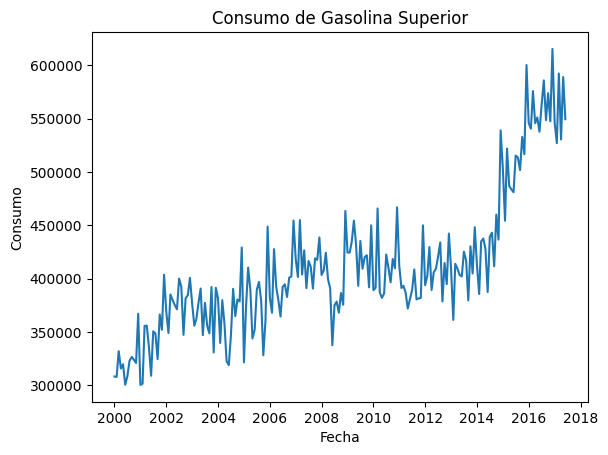

In [13]:
plt.plot(ts_consumo_superior)
plt.gca().set(title="Consumo de Gasolina Superior", xlabel="Fecha", ylabel="Consumo")
plt.show()

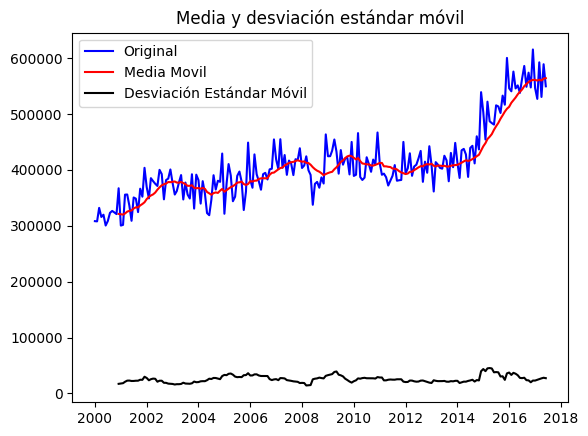

In [14]:
mediaMovil = ts_consumo_superior.rolling(window=12).mean()
deMovil = ts_consumo_superior.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_consumo_superior, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar no parece aumentar ni decrecer, la serie es estacionaria en varianza.

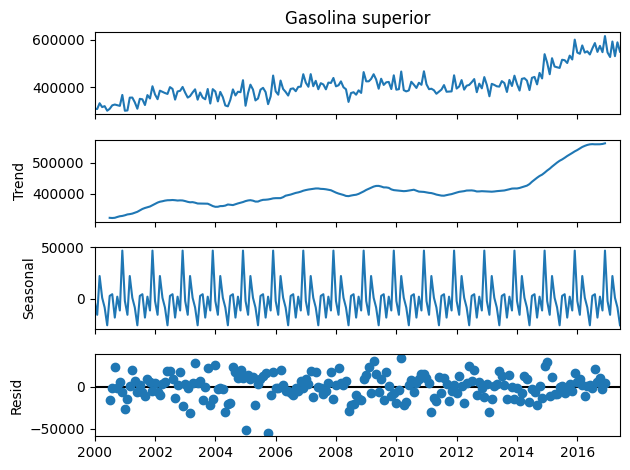

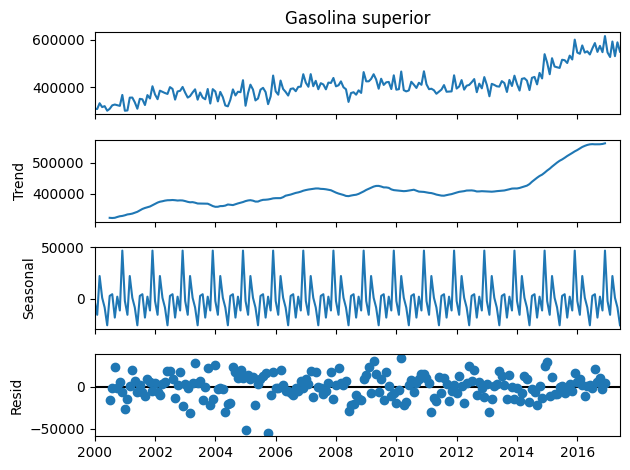

In [15]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_consumo_superior)
descomposicion.plot()

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece ser estacionaria, ya que los residuos se dispersan de manera constante.
- Hay estacionalidad clara, lo que sirve para hacer modeos como SARIMA. 
- No será necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

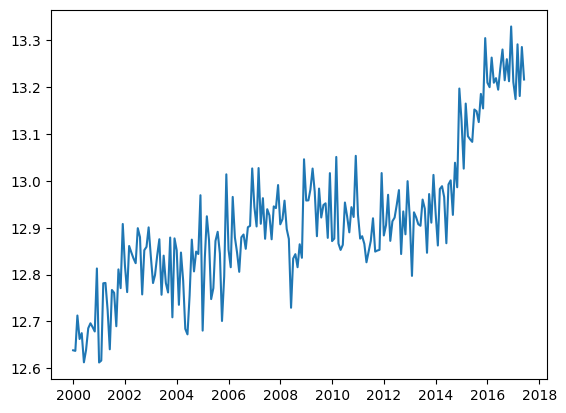

In [16]:
ts_consumo_superior_log = np.log(ts_consumo_superior)
plt.plot(ts_consumo_superior_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la pruebea de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [17]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_consumo_superior, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.211967
p-value                        0.972925
# de retardos usados          12.000000
# de observaciones usadas    197.000000
Critical Value (1%)           -3.463987
Critical Value (5%)           -2.876326
Critical Value (10%)          -2.574652
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [18]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_consumo_superior_diff = ts_consumo_superior.diff()
ts_consumo_superior_diff.dropna(inplace=True)
dfTest = adfuller(ts_consumo_superior_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.469609
p-value                        0.000223
# de retardos usados          11.000000
# de observaciones usadas    197.000000
Critical Value (1%)           -3.463987
Critical Value (5%)           -2.876326
Critical Value (10%)          -2.574652
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

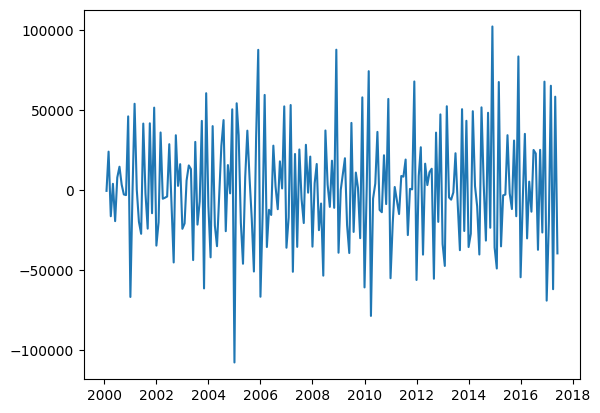

In [19]:
plt.plot(ts_consumo_superior_diff)

No es necesario hacer una transformación logarítmica, solamente diferenciarlo una vez. La serie diferenciada es estacinaria en media y en varianza.

#### Estimar los parámetros del modelo

In [20]:
ts_consumo_superior_diff.dropna(inplace = True)
tsa_acf = acf(ts_consumo_superior_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_consumo_superior_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.48388427, -0.09258392,  0.1125738 , -0.03897311,
        0.26347002])

In [21]:
tsa_pacf

array([ 1.        , -0.48621064, -0.43200572, -0.25908911, -0.22548618,
        0.30971028, -0.17029482, -0.08368773, -0.2351591 ,  0.10704826,
        0.00650634, -0.34845857,  0.31830561,  0.07281629,  0.07990626,
       -0.00272065,  0.00966734,  0.10065402, -0.10450289,  0.00371184,
       -0.08806175,  0.06712348, -0.06528197, -0.10178494,  0.17467489,
       -0.02069443,  0.04460801, -0.07537072,  0.00234058,  0.11117409,
       -0.14465045, -0.1446281 , -0.08645015, -0.03349498,  0.13886484,
       -0.16861824,  0.02001735])

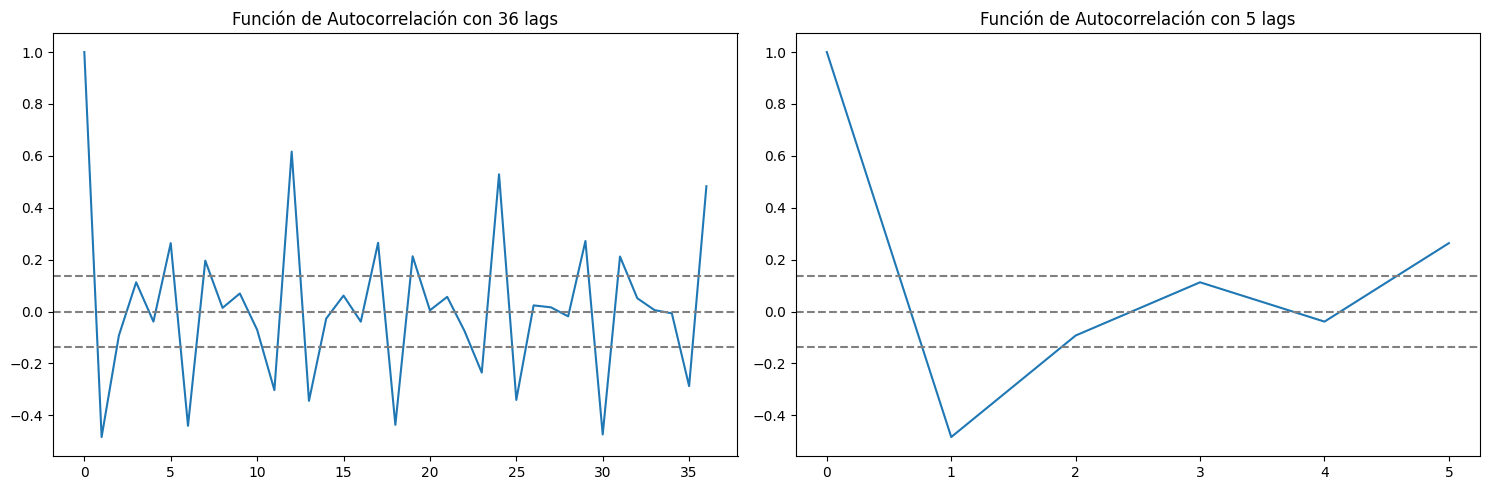

In [22]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_consumo_superior_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_consumo_superior_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()

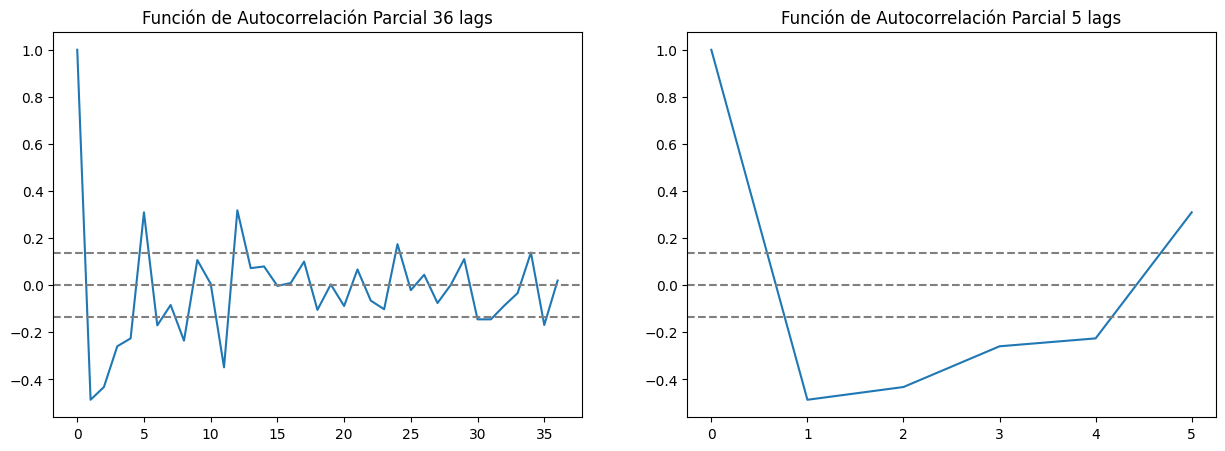

In [23]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_consumo_superior_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_consumo_superior_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 3
- p = 2, d = 1, q = 4

#### Estacionalidad

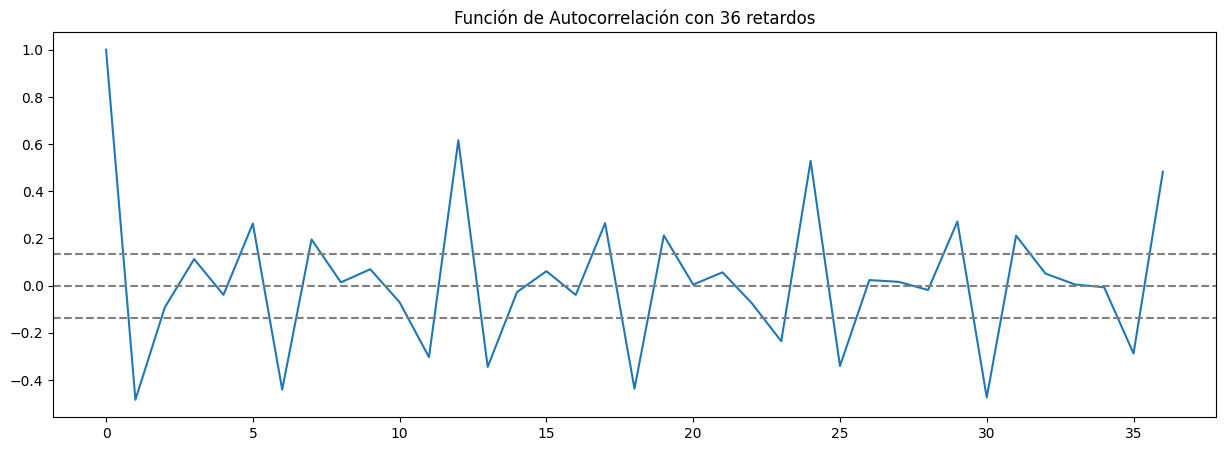

In [24]:
plt.plot(acf(ts_consumo_superior_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar para 12, 24, 36 meses por lo que hay una correlación entre los años, eso indica que hay estacionalidad cada 12 meses. Por lo tanto se le agrega el componente estacional. 

In [25]:
ts_consumo_superior_D = ts_consumo_superior.diff(12)
ts_consumo_superior_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 lags')

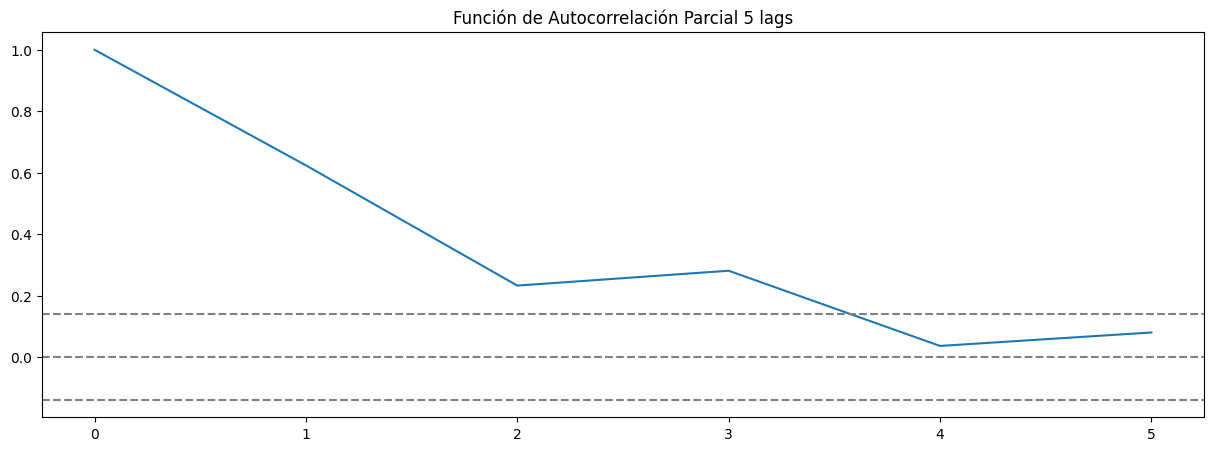

In [169]:

plt.plot(pacf(ts_consumo_superior_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_D)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_D)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. Se probara el siguiente componenete estacional:
- P = 3
- D = 1
- Q = 0

#### Generación de modelos

In [122]:
modelo113_CS = SARIMAX(ts_consumo_superior, order=(1,1,3), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m113_CS = modelo113_CS.fit()
print(resultado_m113_CS.summary().tables[1])

modelo214_CS = SARIMAX(ts_consumo_superior, order=(2,1,4), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m214_CS = modelo214_CS.fit()
print(resultado_m214_CS.summary().tables[1])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2871      0.776     -0.370      0.712      -1.809       1.235
ma.L1         -0.2487      0.790     -0.315      0.753      -1.798       1.300
ma.L2         -0.1929      0.424     -0.455      0.649      -1.024       0.638
ma.L3          0.1498      0.107      1.397      0.162      -0.060       0.360
ar.S.L12      -0.6767      0.106     -6.358      0.000      -0.885      -0.468
ar.S.L24      -0.5171      0.148     -3.484      0.000      -0.808      -0.226
ar.S.L36      -0.2869      0.114     -2.515      0.012      -0.510      -0.063
sigma2      6.542e+08   1.48e-09   4.43e+17      0.000    6.54e+08    6.54e+08


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0850      0.036    -29.921      0.000      -1.156      -1.014
ar.L2         -0.9344      0.041    -22.762      0.000      -1.015      -0.854
ma.L1          0.5967      0.137      4.354      0.000       0.328       0.865
ma.L2          0.4016      0.126      3.192      0.001       0.155       0.648
ma.L3         -0.5386      0.122     -4.400      0.000      -0.779      -0.299
ma.L4         -0.1027      0.127     -0.810      0.418      -0.351       0.146
ar.S.L12      -0.7147      0.140     -5.121      0.000      -0.988      -0.441
ar.S.L24      -0.5244      0.163     -3.226      0.001      -0.843      -0.206
ar.S.L36      -0.2462      0.133     -1.845      0.065      -0.508       0.015
sigma2      6.608e+08   2.61e-11   2.53e+19      0.000    6.61e+08    6.61e+08


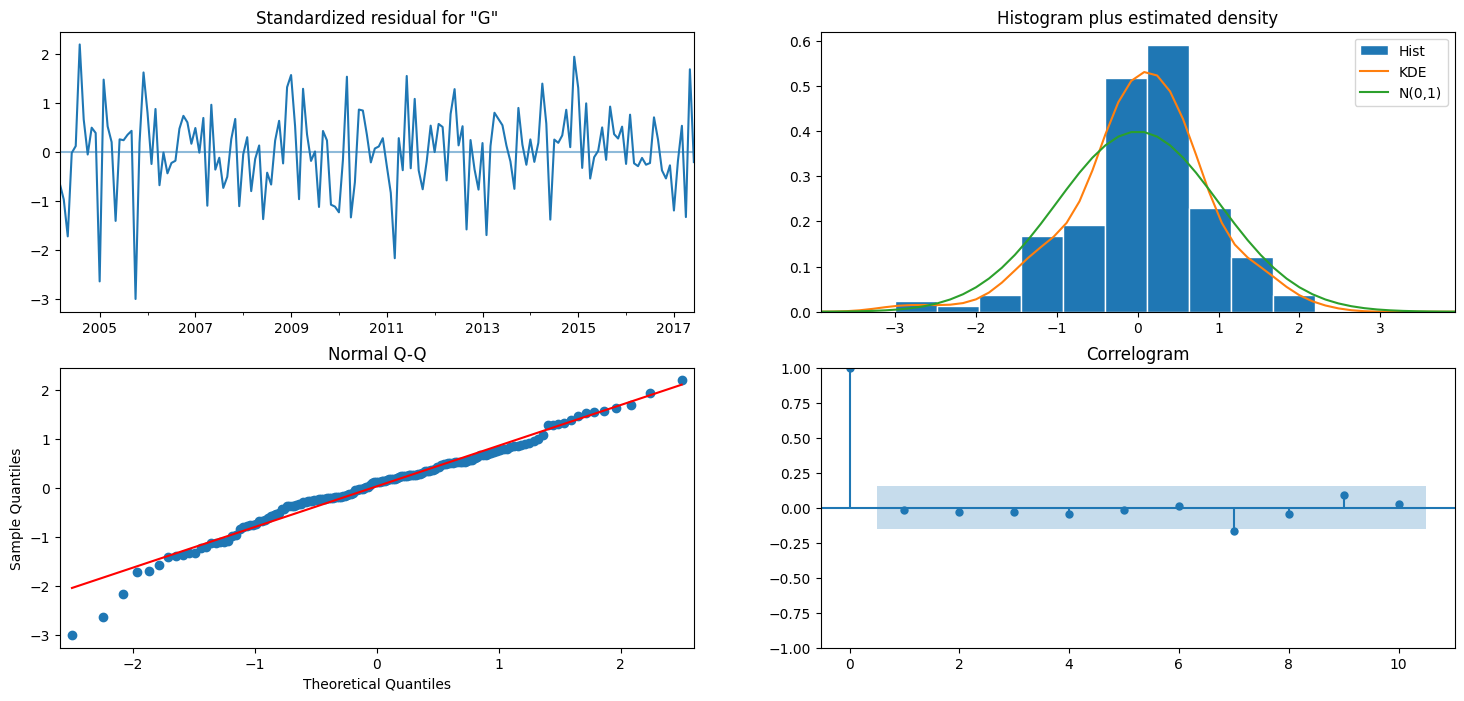

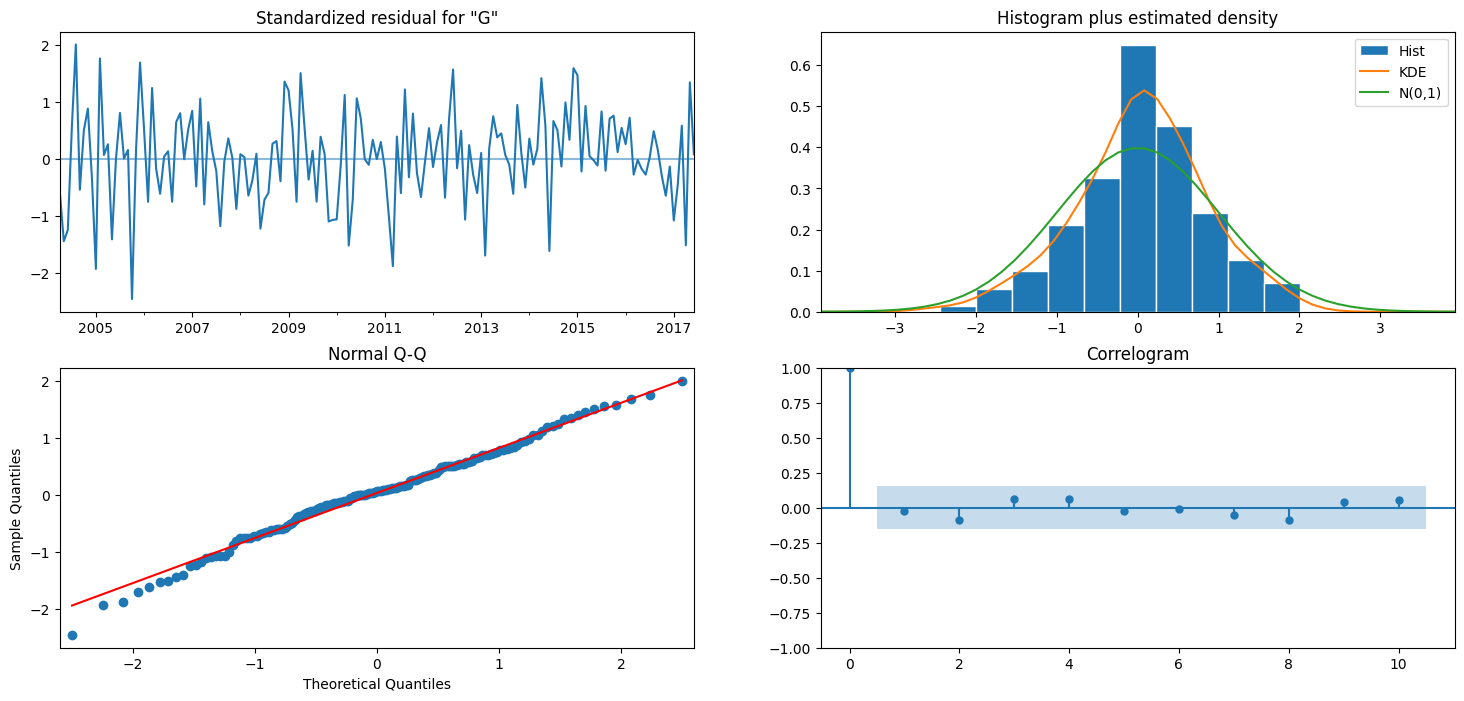

In [123]:
resultado_m113_CS.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m214_CS.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. La varianza es constante.
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control la mayoría de casos. 

In [124]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 113=",resultado_m113_CS.aic)
print("Modelo 214=",resultado_m214_CS.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 113=",resultado_m113_CS.bic)
print("Modelo 214 =",resultado_m214_CS.bic)


Resultados de AIC (Akaike information criterion)
Modelo 113= 3667.8975021034794
Modelo 214= 3641.1445576006736
Resultados de BIC (Bayesian information criterion)
Modelo 113= 3692.49889262535
Modelo 214 = 3671.8335996228757


De acuerdo a ambos indicadores, el mejor el modelo p = 2, d = 1, q = 4, aunque la diferencia es mínima. Este será usado para hacer las predicciones.

#### Prophet

In [141]:
df_prophet_cs = ts_consumo_superior.reset_index()
df_prophet_cs.columns = ['ds', 'y'] 
df_prophet_cs['ds'] = pd.to_datetime(df_prophet_cs['ds'])

modelo_prophet_cs = Prophet(interval_width=0.95, yearly_seasonality=True)
modelo_prophet_cs.fit(df_prophet_cs)  

print(modelo_prophet_cs)


17:27:09 - cmdstanpy - INFO - Chain [1] start processing
17:27:09 - cmdstanpy - INFO - Chain [1] done processing


### <span style="color: blue;">2. Importaciones Gasolina Superior</span>

#### Exploración

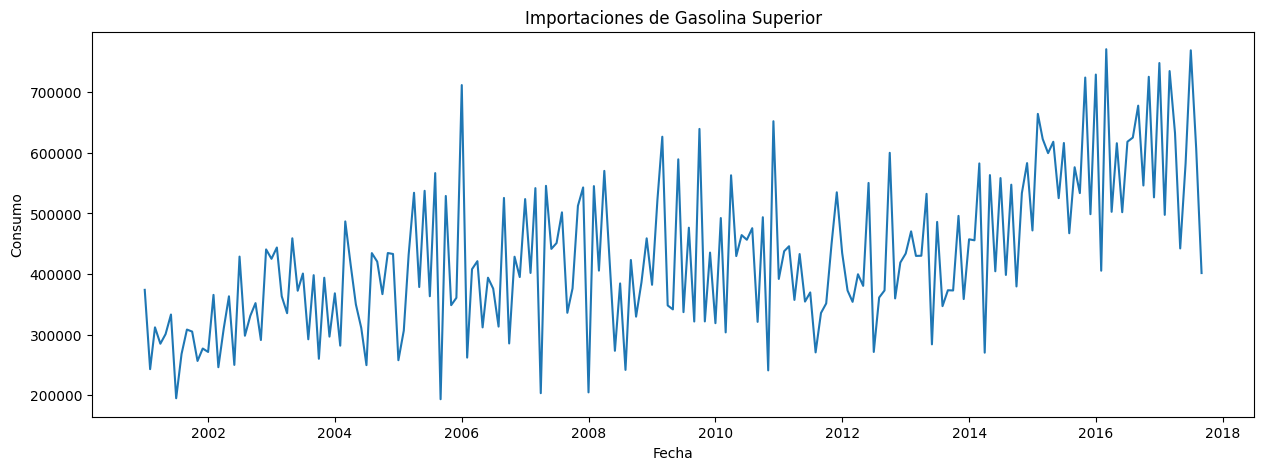

In [30]:
plt.plot(ts_importa_superior)
plt.gca().set(title="Importaciones de Gasolina Superior", xlabel="Fecha", ylabel="Consumo")
plt.show()

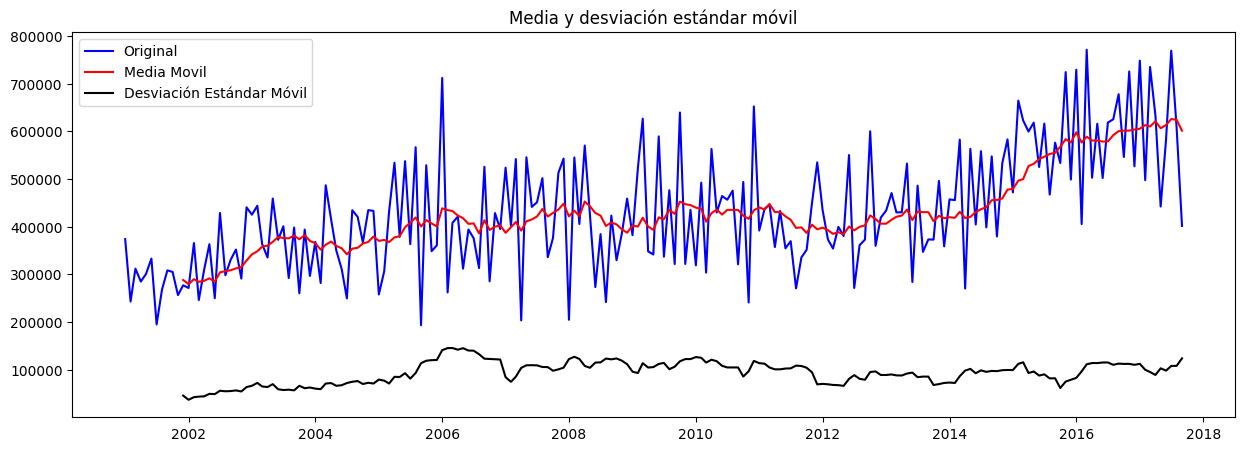

In [31]:
mediaMovil = ts_importa_superior.rolling(window=12).mean()
deMovil = ts_importa_superior.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_importa_superior, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar aumenta hasta el 2006, luego se mantiene bastante constante. 

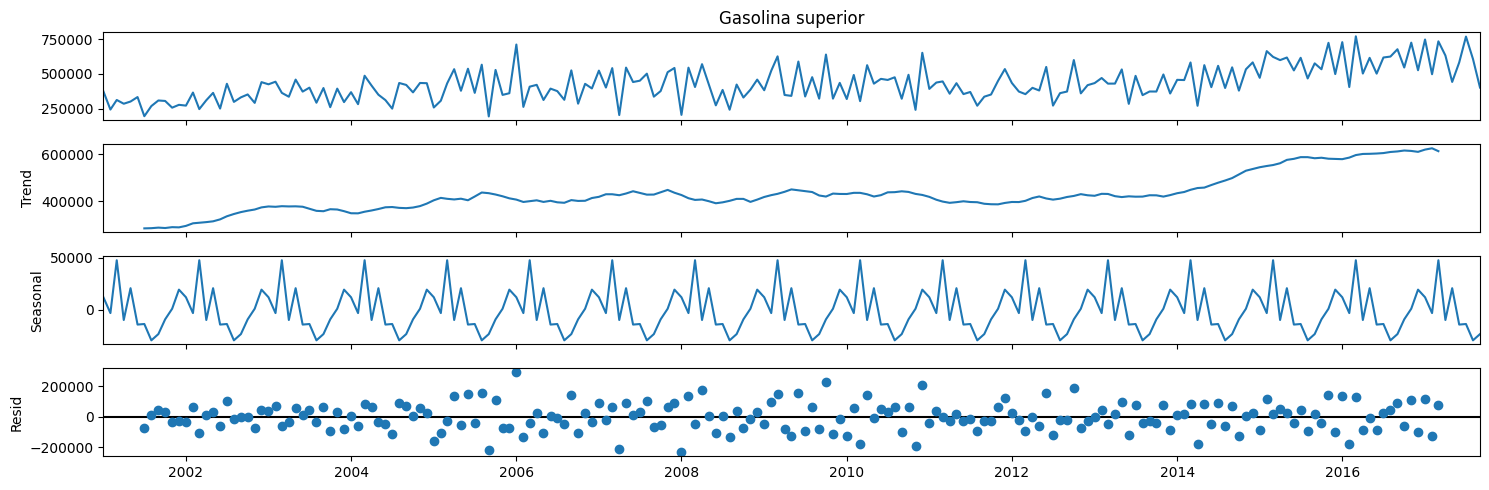

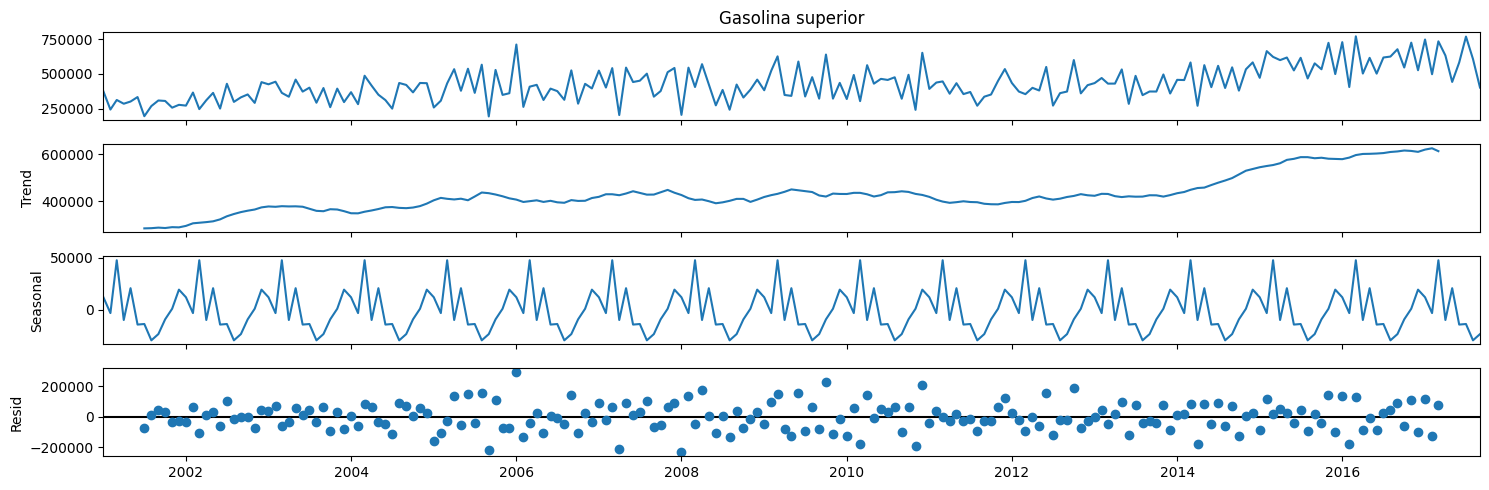

In [32]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_importa_superior)
descomposicion.plot()

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece ser estacionaria, ya que los residuos se dispersan de manera constante.
- Hay estacionalidad clara, lo que sirve para hacer modeos como SARIMA. 
- No será necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

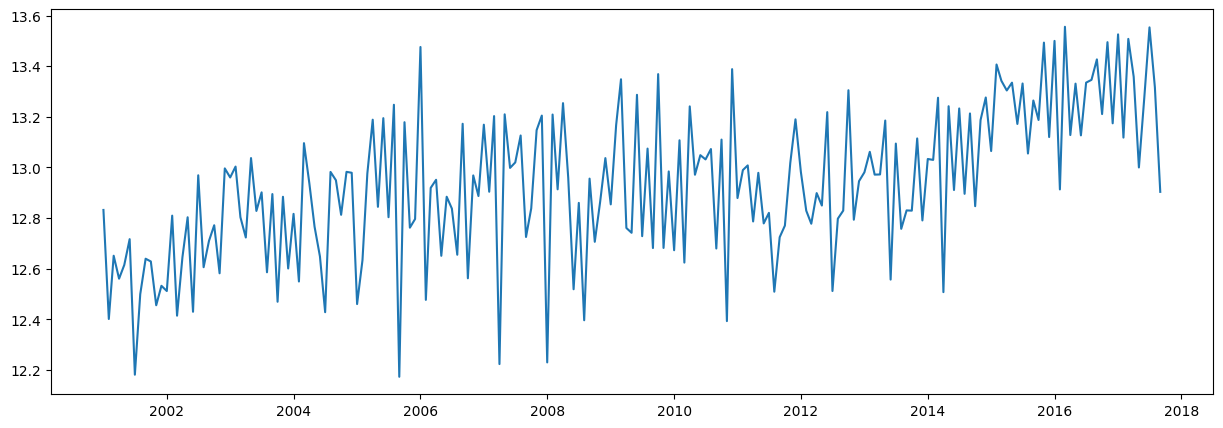

In [33]:
ts_importa_superior_log = np.log(ts_importa_superior)
plt.plot(ts_importa_superior_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la pruebea de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [34]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_importa_superior, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.740516
p-value                        0.410367
# de retardos usados           5.000000
# de observaciones usadas    195.000000
Critical Value (1%)           -3.464337
Critical Value (5%)           -2.876479
Critical Value (10%)          -2.574733
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [35]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_importa_superior_diff = ts_importa_superior.diff()
ts_importa_superior_diff.dropna(inplace=True)
dfTest = adfuller(ts_importa_superior_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.435867e+00
p-value                      6.185990e-11
# de retardos usados         9.000000e+00
# de observaciones usadas    1.900000e+02
Critical Value (1%)         -3.465244e+00
Critical Value (5%)         -2.876875e+00
Critical Value (10%)        -2.574945e+00
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

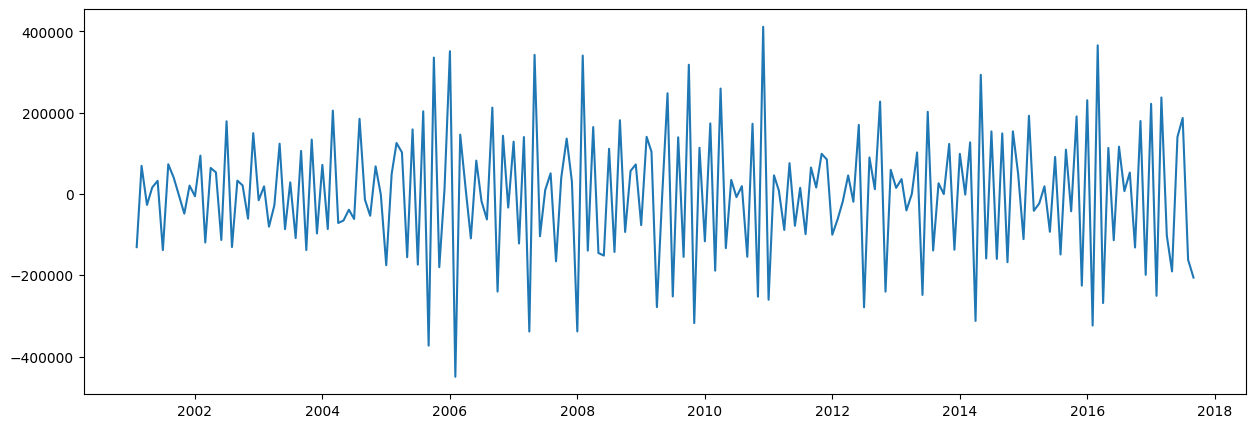

In [36]:
plt.plot(ts_importa_superior_diff)

No es necesario hacer una transformación logarítmica, solamente diferenciarlo una vez. La serie diferenciada es estacinaria en media y en varianza.

#### Estimar los parámetros del modelo

In [37]:
ts_importa_superior_diff.dropna(inplace = True)
tsa_acf = acf(ts_importa_superior_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_importa_superior_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.71930771,  0.37755078, -0.26692336,  0.19439904,
       -0.14144492])

In [38]:
tsa_pacf

array([ 1.        , -0.72292232, -0.29588855, -0.29298354, -0.18403606,
       -0.16590651, -0.02831117, -0.10667051, -0.04410251, -0.0530243 ,
       -0.07615672,  0.07558245,  0.04716775, -0.05305527,  0.03534489,
       -0.09423723, -0.05426794,  0.11400876, -0.04719496, -0.0312414 ,
        0.02362334, -0.12125186, -0.00333924,  0.06451361, -0.07548787,
       -0.14154735,  0.03749039, -0.06055861,  0.10547504,  0.09781687,
        0.17552424, -0.06258918, -0.04156148, -0.03626307, -0.11123928,
        0.05378613, -0.09418115])

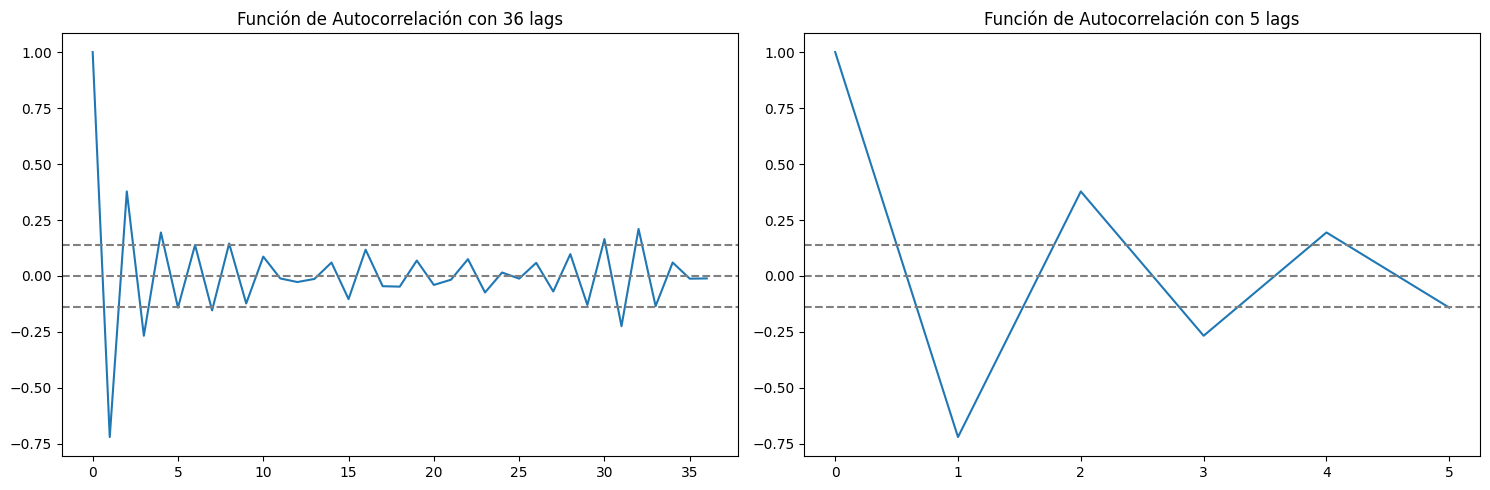

In [39]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_importa_superior_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_importa_superior_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()

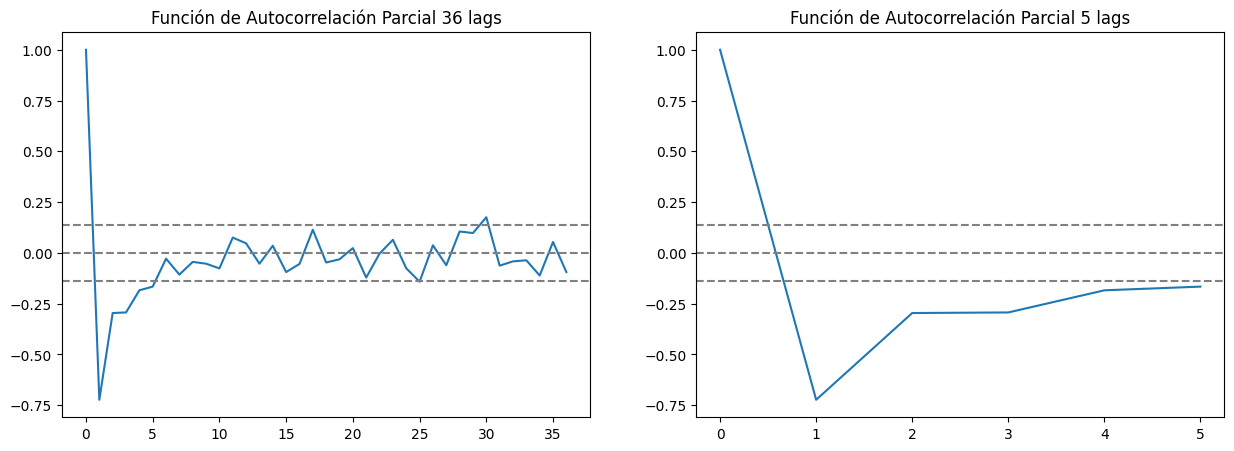

In [40]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_importa_superior_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_importa_superior_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 2
- p = 2, d = 1, q = 4

#### Estacionalidad

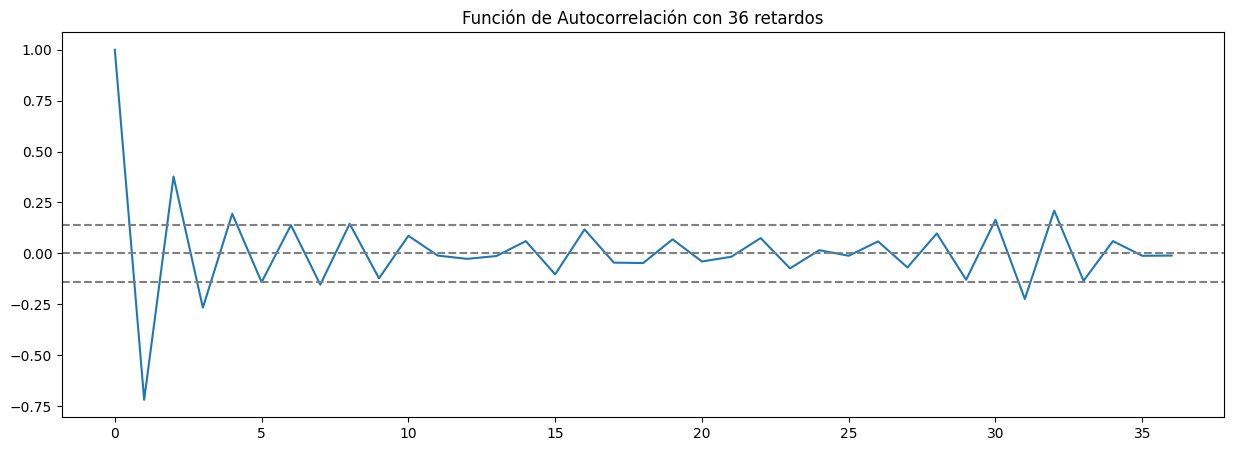

In [41]:
plt.plot(acf(ts_importa_superior_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en el gráfico, el comportamiento es similar para todas las estaciones, no se puede decirque haya estacionalidad cada 12 meses. No es necesario agregar el componente estacional. Se usa solo ARIMA.

#### Generación de modelos

In [184]:
modelo112_IS = ARIMA(ts_importa_superior, order=(1,1,2))
resultado_m112_IS = modelo112_IS.fit()
print(resultado_m112_IS.summary().tables[1])

modelo214_IS = ARIMA(ts_importa_superior, order=(2,1,4))
resultado_m214_IS = modelo214_IS.fit()
print(resultado_m214_IS.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6041      0.150     -4.019      0.000      -0.899      -0.309
ma.L1         -0.5897      0.175     -3.365      0.001      -0.933      -0.246
ma.L2         -0.1956      0.168     -1.166      0.244      -0.524       0.133
sigma2      9.137e+09   1.92e-11   4.75e+20      0.000    9.14e+09    9.14e+09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5247     15.902     -0.096      0.924     -32.692      29.643
ar.L2         -0.5824     12.547     -0.046      0.963     -25.175      24.010
ma.L1          0.3213     15.890      0.020      0.984     -30.822      31.464
ma.L2         -0.7630      6.584     -0.116      0.908     -13.667      12.141
ma.L3         -0.2173      7.279     -0.030      0.9

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

In [ ]:
from pmdarima import auto_arima
modelo_optimo = auto_arima(ts_importa_superior, 
                         start_p=0, start_q=0, 
                         max_p=3, max_q=3, 
                         seasonal=False,
                         stepwise=True,
                         suppress_warnings=True)

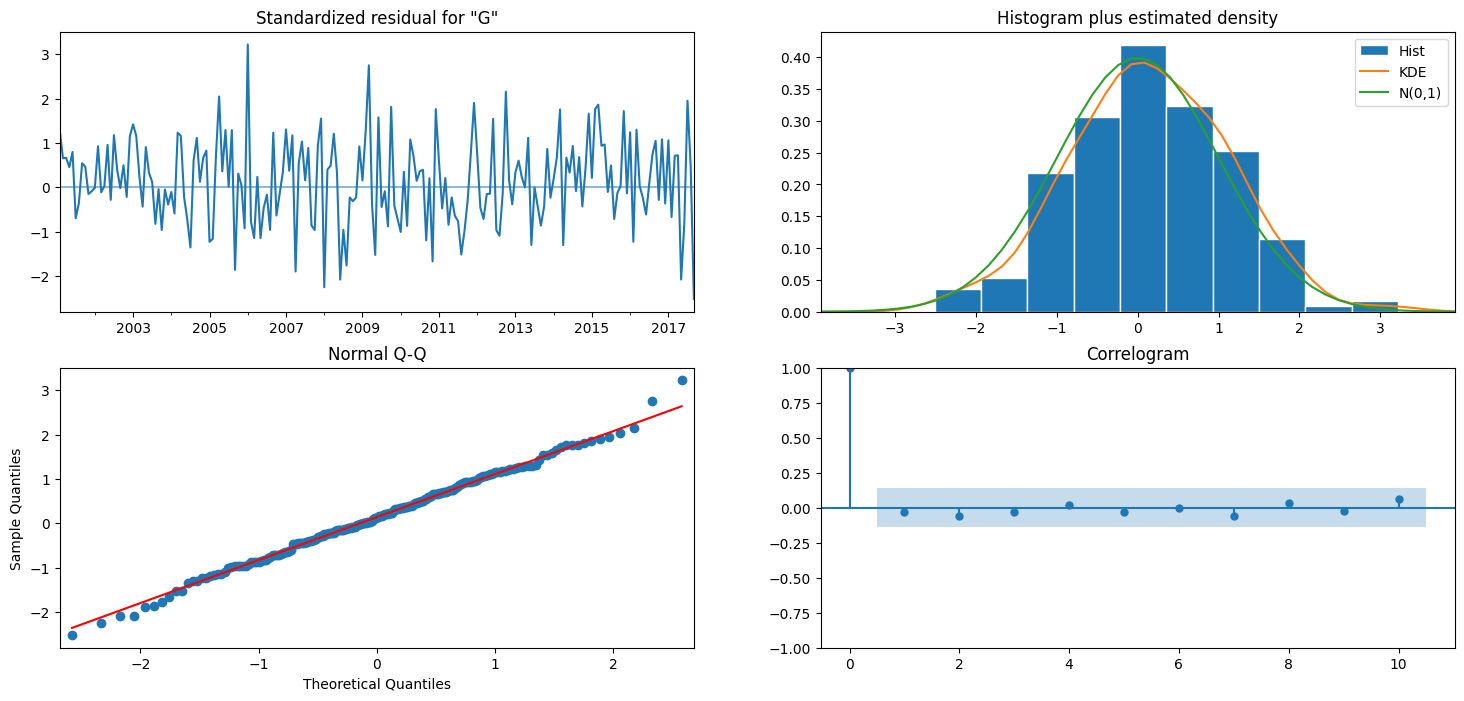

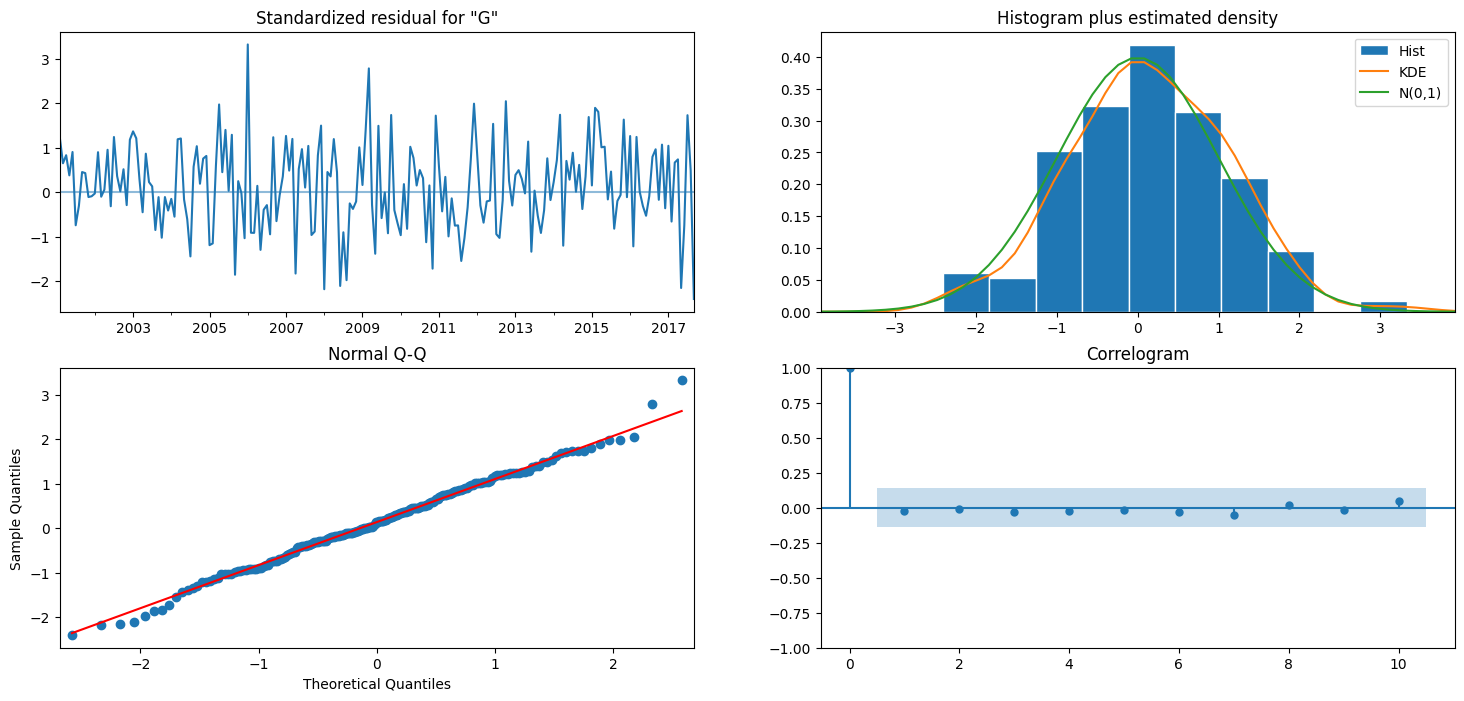

In [43]:
resultado_m112_IS.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m214_IS.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. La varianza es constante.
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control la mayoría de casos. 

In [44]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 112=",resultado_m112_IS.aic)
print("Modelo 214=",resultado_m214_IS.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 112=",resultado_m112_IS.bic)
print("Modelo 214 =",resultado_m214_IS.bic)

Resultados de AIC (Akaike information criterion)
Modelo 112= 5154.758555785307
Modelo 214= 5159.49670954599
Resultados de BIC (Bayesian information criterion)
Modelo 112= 5167.951825251499
Modelo 214 = 5182.584931111826


De acuerdo a ambos indicadores, el mejor el modelo p = 1, d = 1, q = 2, aunque la diferencia es mínima. Este será usado para hacer las predicciones.

#### Prophet

In [166]:
df_prophet_is = ts_importa_superior.reset_index()
df_prophet_is.columns = ['ds', 'y'] 
df_prophet_is['ds'] = pd.to_datetime(df_prophet_is['ds'])

modelo_prophet_is = Prophet(interval_width=0.95, yearly_seasonality=True)
modelo_prophet_is.fit(df_prophet_is)  

print(modelo_prophet_is)


18:01:34 - cmdstanpy - INFO - Chain [1] start processing


18:01:34 - cmdstanpy - INFO - Chain [1] done processing


### <span style="color: blue;">3. Consumo Gasolina Regular</span>

#### Exploración

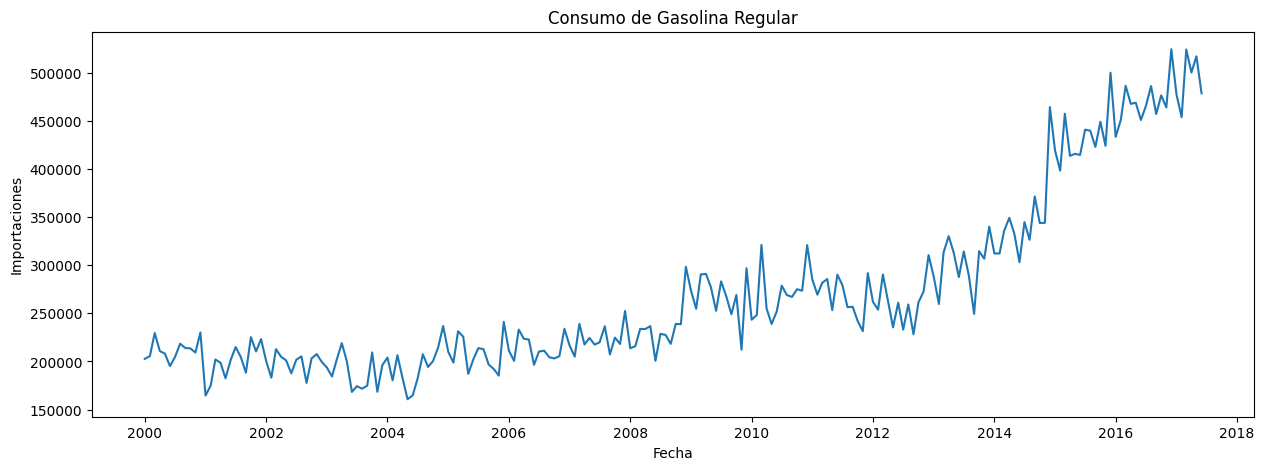

In [45]:
plt.plot(ts_consumo_regular)
plt.gca().set(title="Consumo de Gasolina Regular", xlabel="Fecha", ylabel="Importaciones")
plt.show()

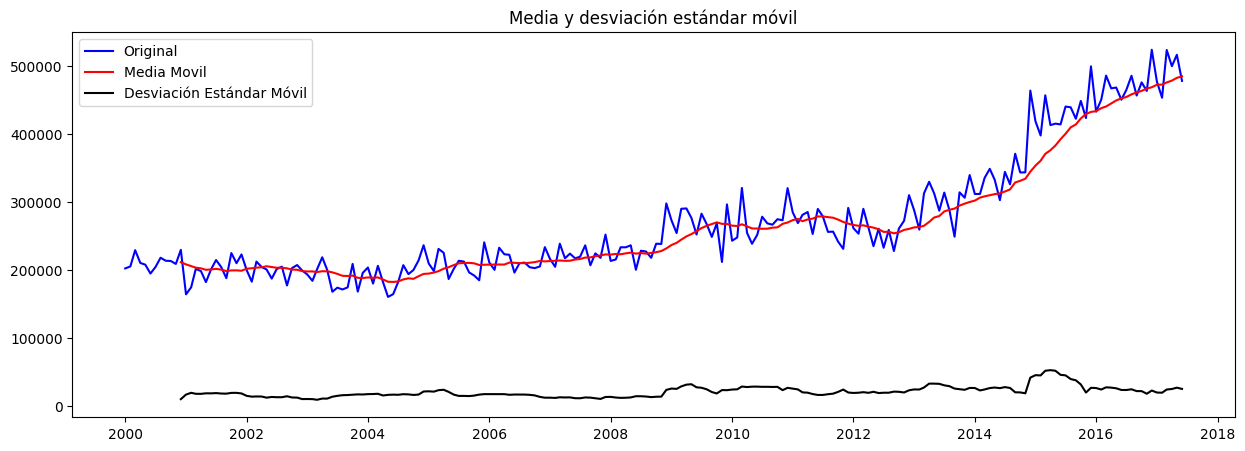

In [46]:
mediaMovil = ts_consumo_regular.rolling(window=12).mean()
deMovil = ts_consumo_regular.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_consumo_regular, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la gráfica de la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar también parece aumentar a lo largo del tiempo, lo que indica que la serie puede no ser estacionaria en varianza.

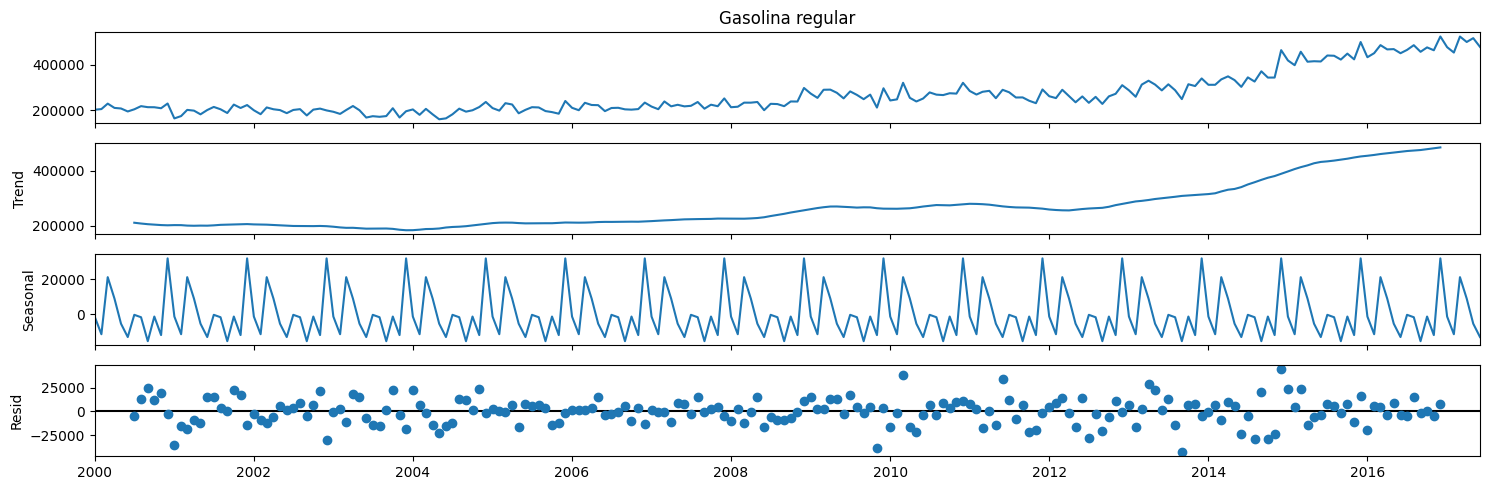

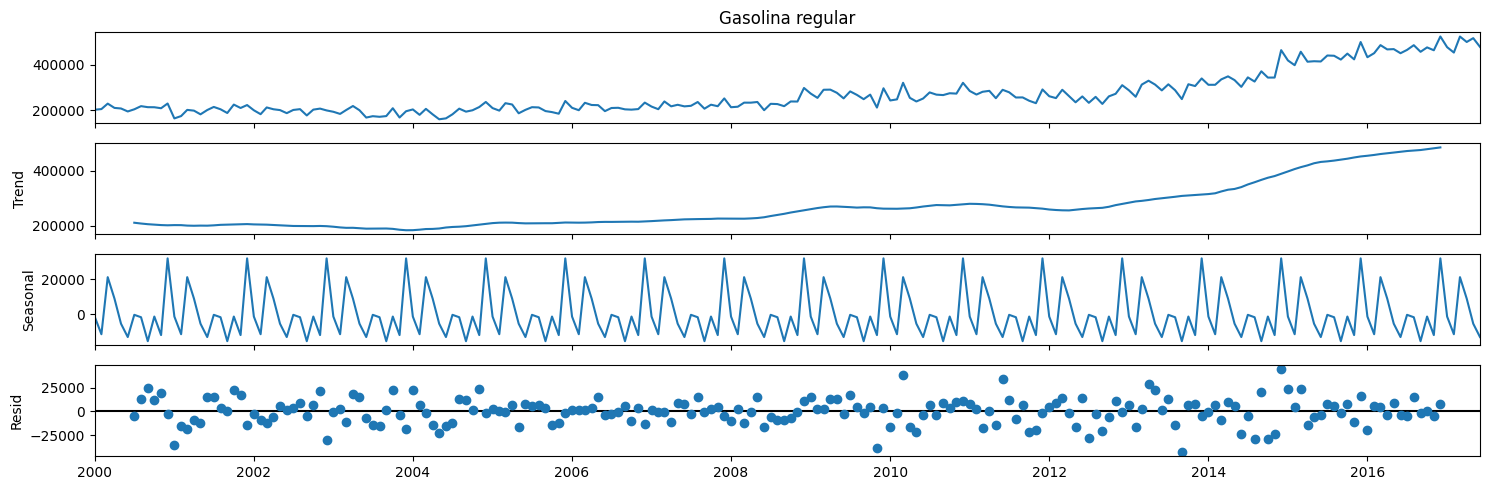

In [47]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_consumo_regular)
descomposicion.plot()

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece no ser estacionaria, ya que los residuos se dispersan más en el tiempo. 
- Hay estacionalidad clara, lo que sirve para hacer modeos como SARIMA. 
- Será no  es necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

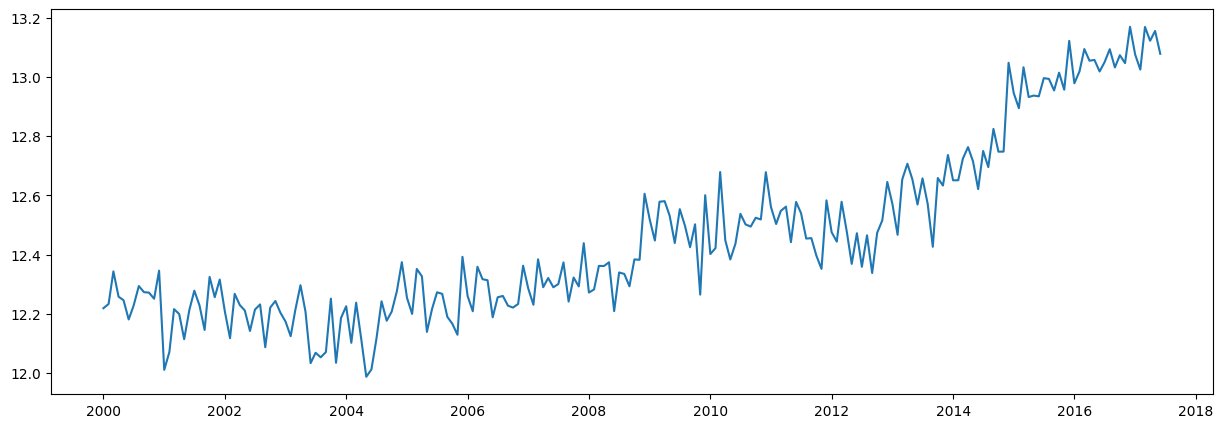

In [48]:
ts_consumo_regular_log = np.log(ts_consumo_regular)
plt.plot(ts_consumo_regular_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la pruebea de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [49]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_consumo_regular, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          1.923047
p-value                        0.998564
# de retardos usados          12.000000
# de observaciones usadas    197.000000
Critical Value (1%)           -3.463987
Critical Value (5%)           -2.876326
Critical Value (10%)          -2.574652
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [50]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_consumo_regular_diff = ts_consumo_regular.diff()
ts_consumo_regular_diff.dropna(inplace=True)
dfTest = adfuller(ts_consumo_regular_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -3.687785
p-value                        0.004288
# de retardos usados          12.000000
# de observaciones usadas    196.000000
Critical Value (1%)           -3.464161
Critical Value (5%)           -2.876402
Critical Value (10%)          -2.574692
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

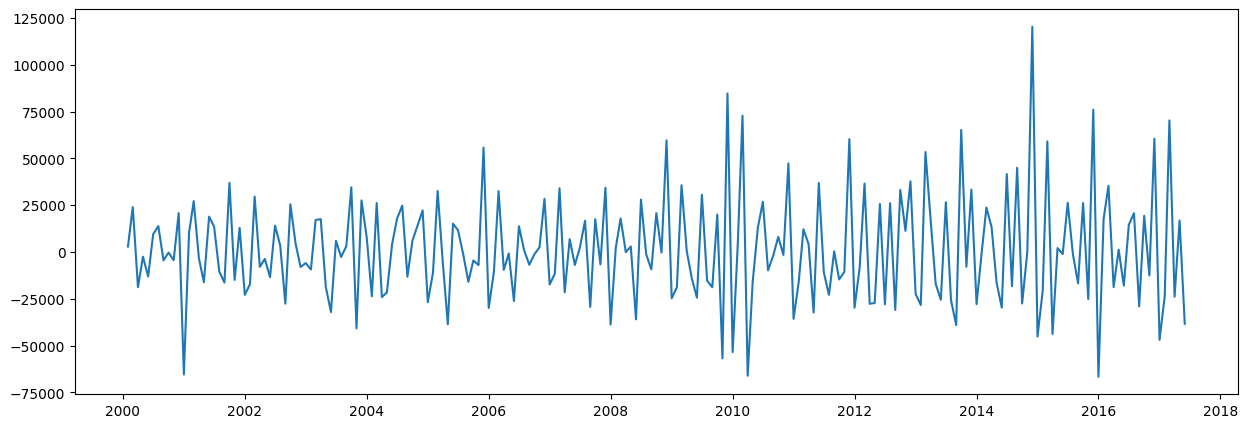

In [51]:
plt.plot(ts_consumo_regular_diff)

No es necesario hacer una transformación logarítmica, solamente diferenciarlo una vez. La serie diferenciada es estacinaria en media y en varianza.

#### Estimar los parámetros del modelo

In [52]:
ts_consumo_regular_diff.dropna(inplace = True)
tsa_acf = acf(ts_consumo_regular_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_consumo_regular_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.45281258, -0.12938224,  0.18079682, -0.07829807,
        0.16501459])

In [53]:
tsa_pacf

array([ 1.        , -0.45498956, -0.42579371, -0.14640096, -0.13227828,
        0.20397072, -0.12035164, -0.07799082, -0.21841328,  0.16731931,
        0.00378501, -0.28096787,  0.28596516,  0.11677782,  0.03850329,
       -0.00817083,  0.05108659,  0.14785317, -0.02269746, -0.07870158,
       -0.10902107,  0.03253879,  0.03073829, -0.08882141,  0.22309185,
        0.15052661, -0.00314755, -0.03562986,  0.18100236,  0.07352272,
       -0.03797879, -0.10466251, -0.07373888, -0.06341513,  0.02805129,
       -0.21215816, -0.04161744])

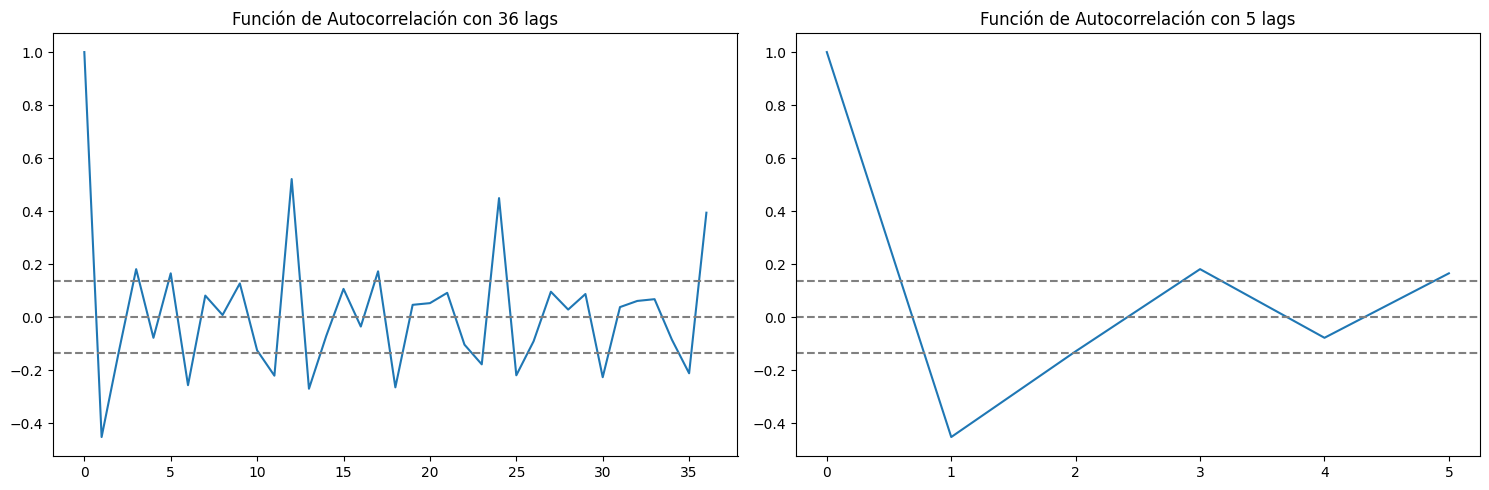

In [54]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_consumo_regular_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_consumo_regular_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()

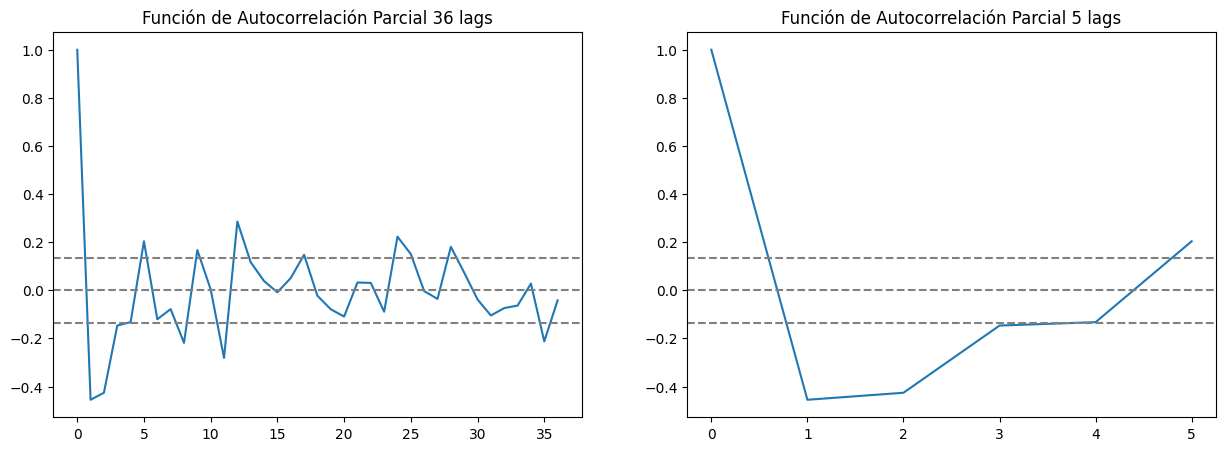

In [55]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_consumo_regular_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_consumo_regular_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 2
- p = 2, d = 1, q = 3

#### Estacionalidad

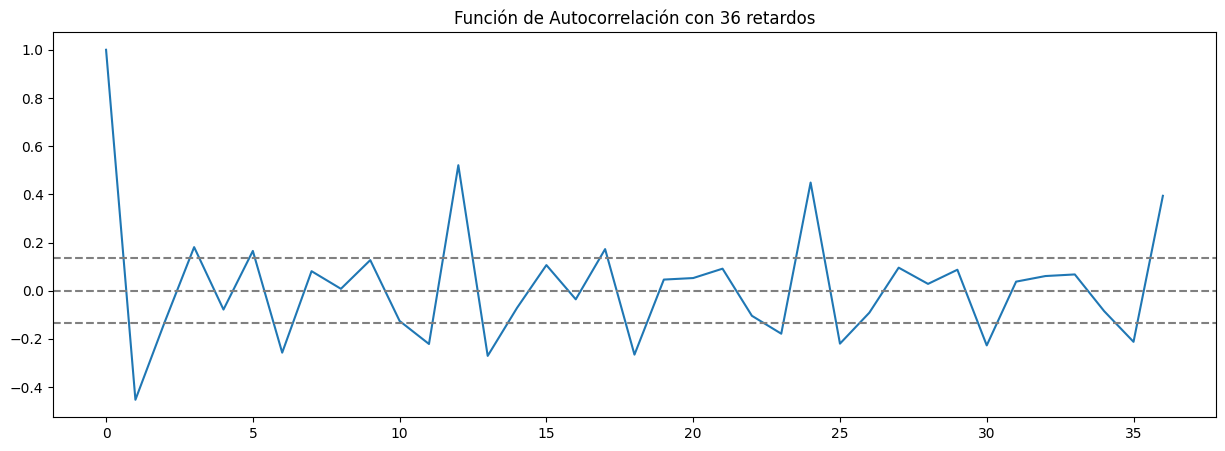

In [56]:
plt.plot(acf(ts_consumo_regular_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar para 12, 24, 36 meses por lo que hay una correlación entre los años, eso indica que hay estacionalidad cada 12 meses. Por lo tanto se le agrega el componente estacional. 

In [57]:
ts_consumo_regular_D = ts_consumo_regular.diff(12)
ts_consumo_regular_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 lags')

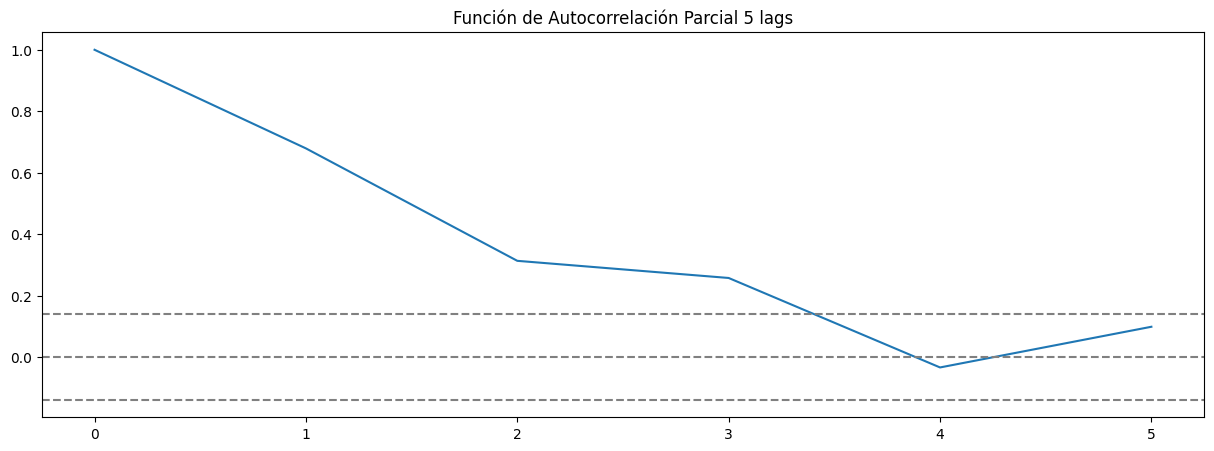

In [58]:

plt.plot(pacf(ts_consumo_regular_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_regular_D)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_regular_D)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. Se probara el siguiente componenete estacional:
- P = 3
- D = 1
- Q = 0

In [59]:
modelo112_CS = SARIMAX(ts_consumo_regular, order=(1,1,2), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m112_CS = modelo112_CS.fit()
print(resultado_m112_CS.summary().tables[1])

modelo213_CS = SARIMAX(ts_consumo_regular, order=(2,1,3), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m213_CS = modelo213_CS.fit()
print(resultado_m213_CS.summary().tables[1])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8296      0.139     -5.982      0.000      -1.101      -0.558
ma.L1          0.3334      0.150      2.222      0.026       0.039       0.627
ma.L2         -0.5455      0.111     -4.917      0.000      -0.763      -0.328
ar.S.L12      -0.7321      0.120     -6.077      0.000      -0.968      -0.496
ar.S.L24      -0.4946      0.157     -3.150      0.002      -0.802      -0.187
ar.S.L36      -0.3145      0.137     -2.303      0.021      -0.582      -0.047
sigma2      5.421e+08   2.47e-10    2.2e+18      0.000    5.42e+08    5.42e+08


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2167      0.510     -2.387      0.017      -2.216      -0.217
ar.L2         -0.4771      0.452     -1.056      0.291      -1.363       0.408
ma.L1          0.6356      0.561      1.133      0.257      -0.464       1.735
ma.L2         -0.2378      0.264     -0.902      0.367      -0.755       0.279
ma.L3         -0.0804      0.346     -0.232      0.816      -0.759       0.598
ar.S.L12      -0.7808      0.119     -6.536      0.000      -1.015      -0.547
ar.S.L24      -0.5496      0.168     -3.278      0.001      -0.878      -0.221
ar.S.L36      -0.3685      0.144     -2.550      0.011      -0.652      -0.085
sigma2      5.292e+08   8.51e-10   6.22e+17      0.000    5.29e+08    5.29e+08


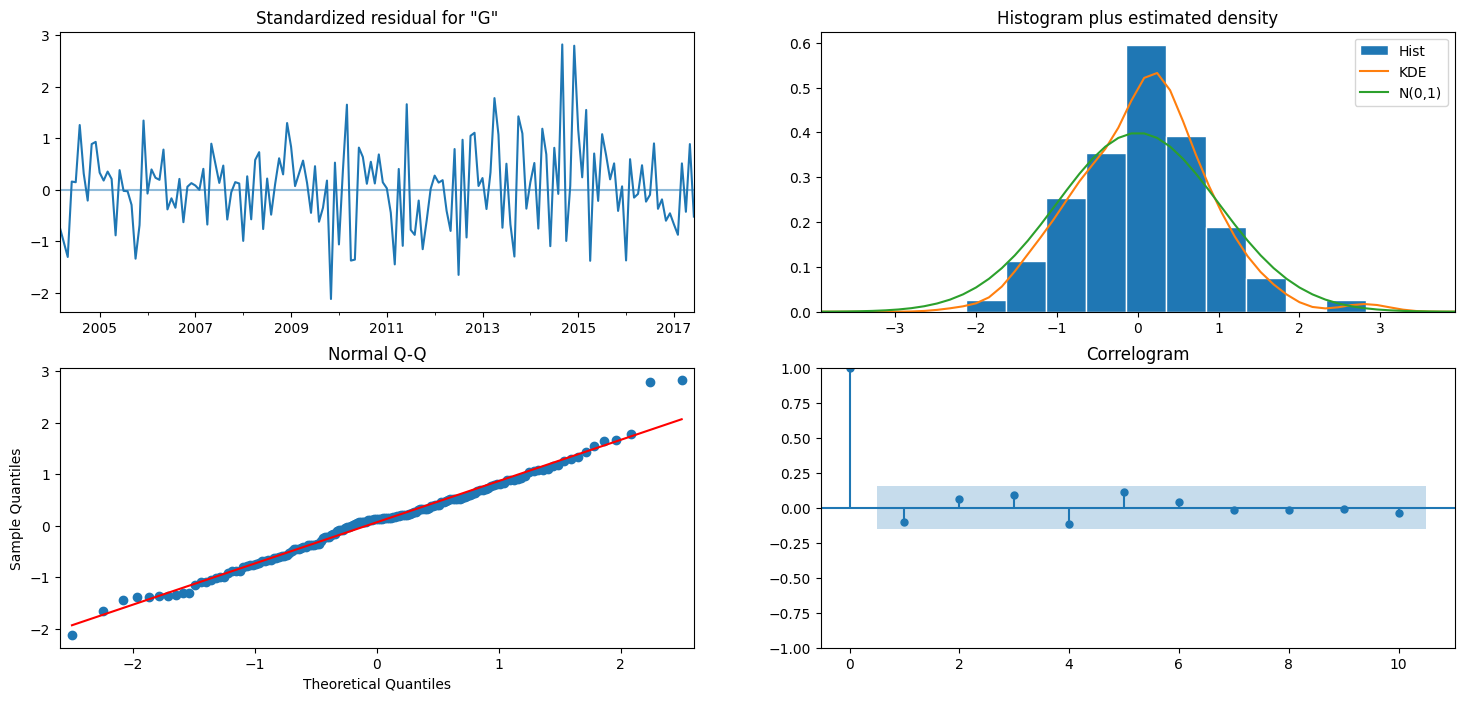

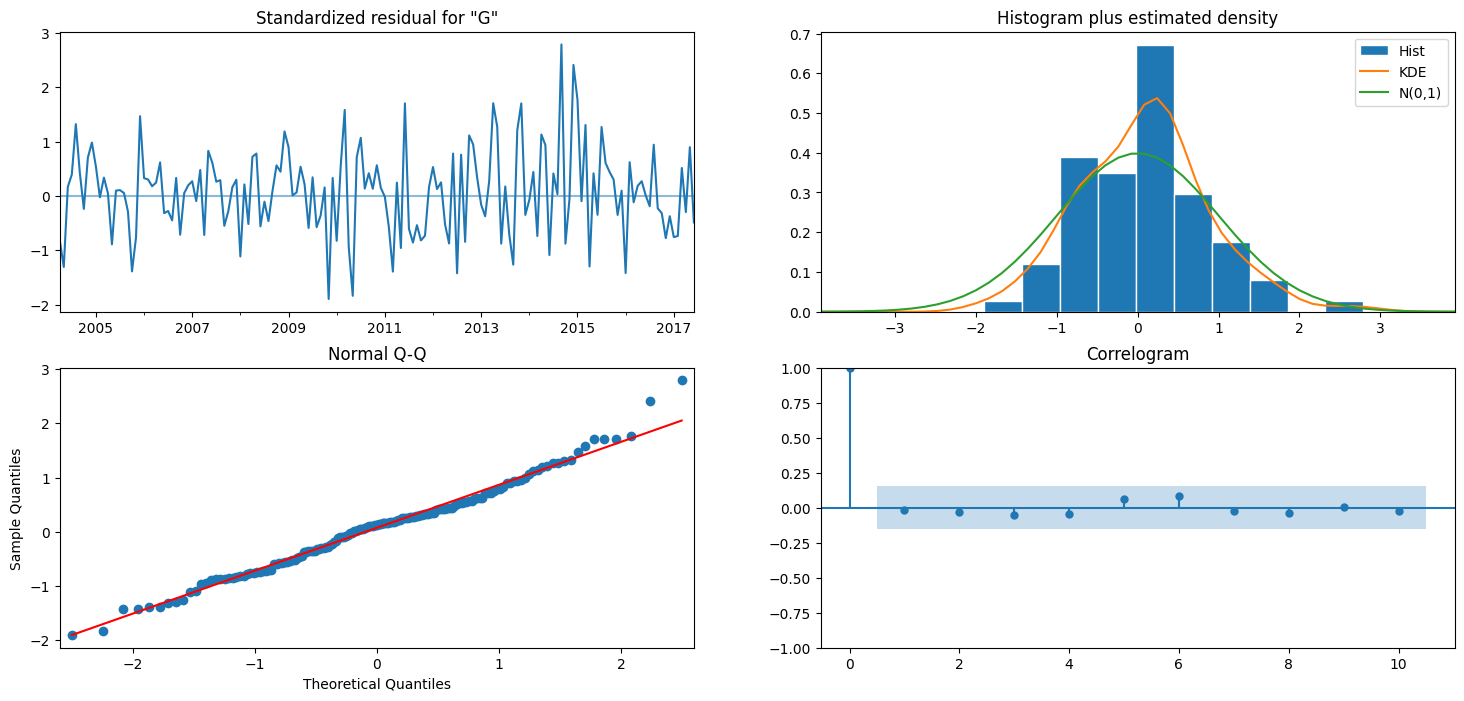

In [60]:
resultado_m112_CS.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m213_CS.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. La varianza es constante.
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control la mayoría de casos. 

In [61]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 113=",resultado_m112_CS.aic)
print("Modelo 214=",resultado_m213_CS.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 113=",resultado_m112_CS.bic)
print("Modelo 214 =",resultado_m213_CS.bic)


Resultados de AIC (Akaike information criterion)
Modelo 113= 3628.8602105656596
Modelo 214= 3604.506098006824
Resultados de BIC (Bayesian information criterion)
Modelo 113= 3650.3864272722963
Modelo 214 = 3632.126235826806


De acuerdo a ambos indicadores, el mejor el modelo p = 2, d = 1, q = 4, aunque la diferencia es mínima. Este será usado para hacer las predicciones.

### <span style="color: blue;">4. Importaciones Gasolina Regular</span>

#### Exploración

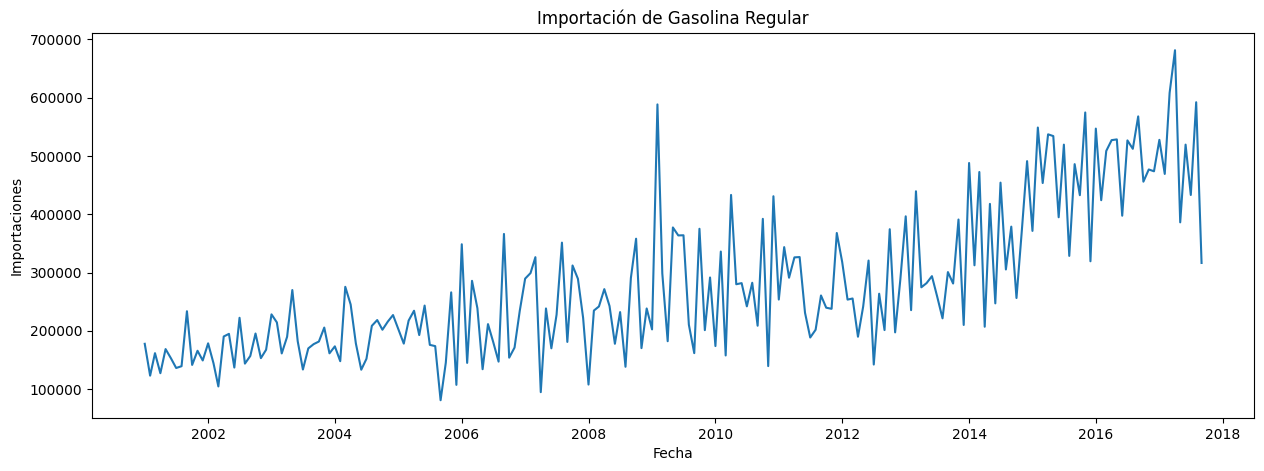

In [62]:
plt.plot(ts_importa_regular)
plt.gca().set(title="Importación de Gasolina Regular", xlabel="Fecha", ylabel="Importaciones")
plt.show()

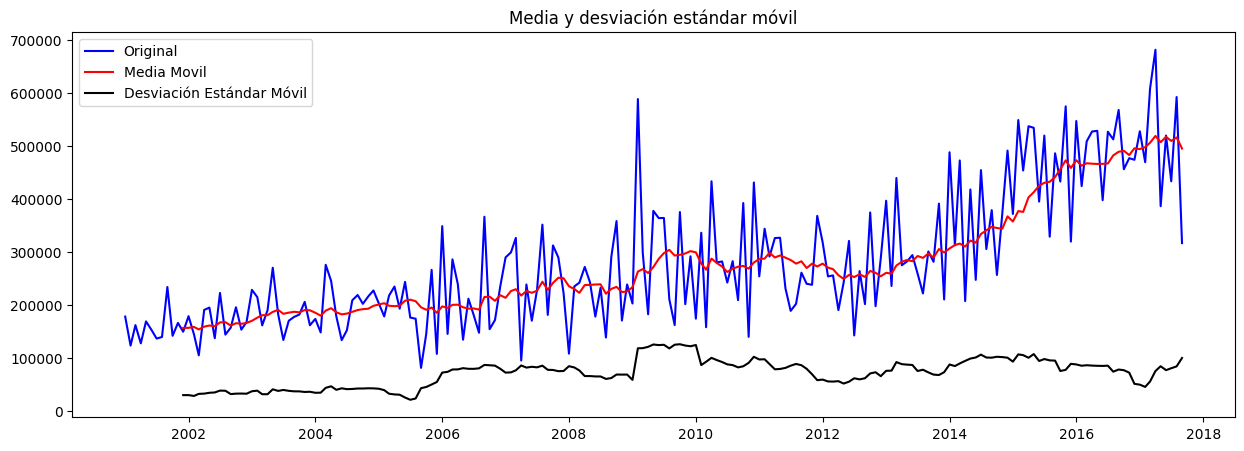

In [63]:
mediaMovil = ts_importa_regular.rolling(window=12).mean()
deMovil = ts_importa_regular.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_importa_regular, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la gráfica de la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar también parece aumentar a lo largo del tiempo, lo que indica que la serie puede no ser estacionaria en varianza.

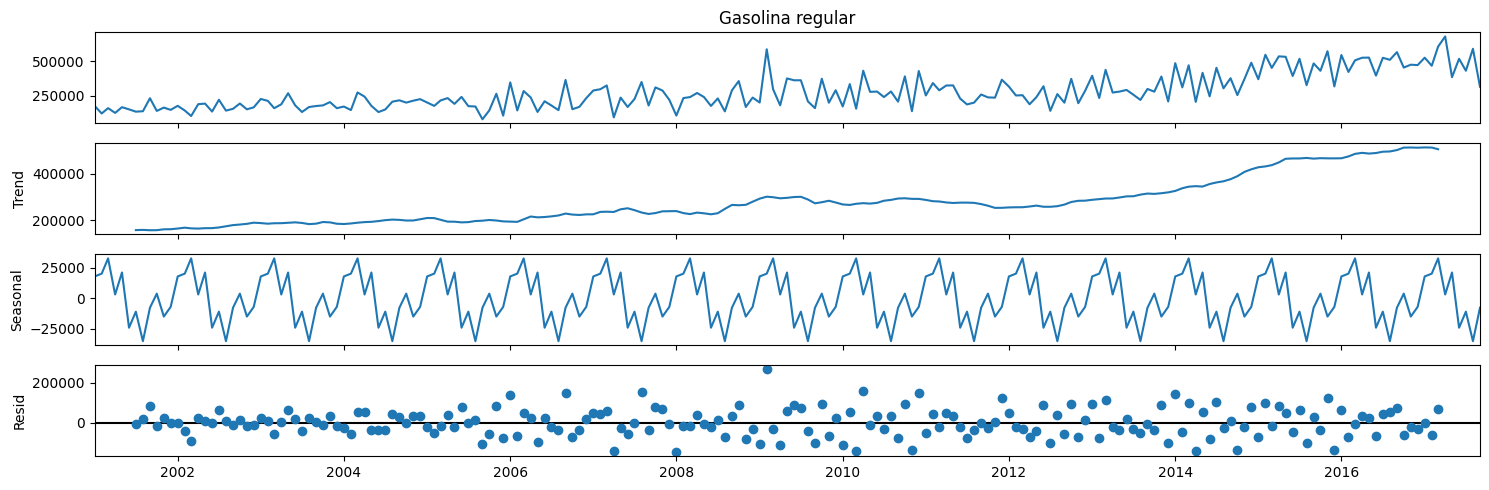

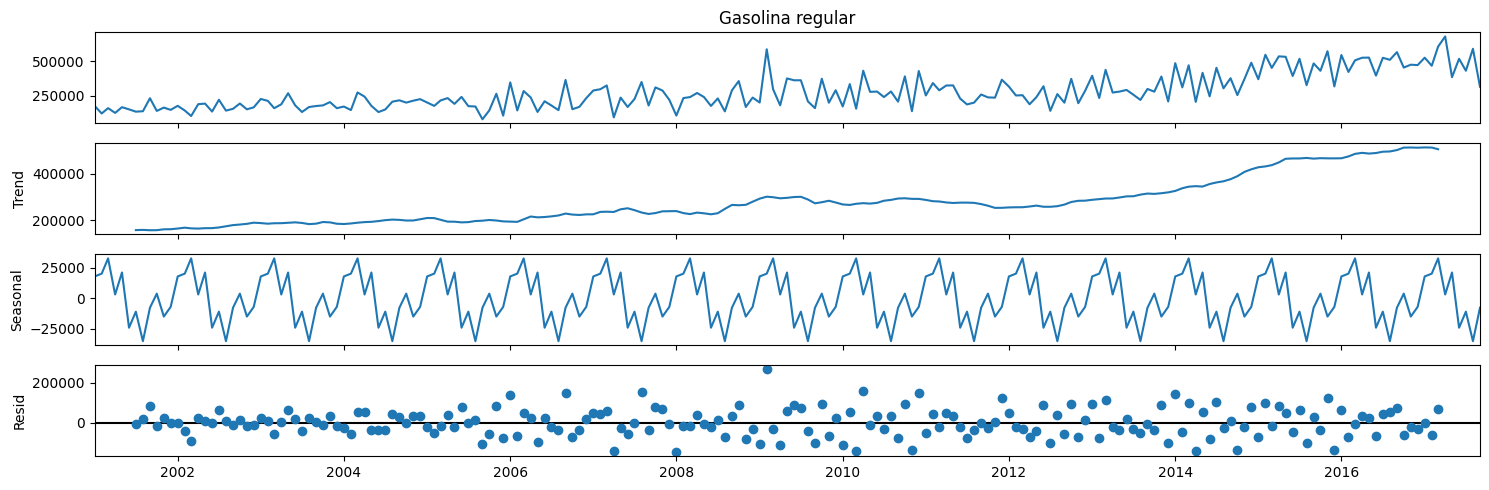

In [64]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_importa_regular)
descomposicion.plot()

En la gráfica se observa que la gráfica de la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar también parece aumentar a lo largo del tiempo, lo que indica que la serie puede no ser estacionaria en varianza.

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece no ser estacionaria, ya que los residuos se dispersan más en el tiempo. 
- Hay estacionalidad clara, lo que sirve para hacer modeos como SARIMA. 
- Será necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

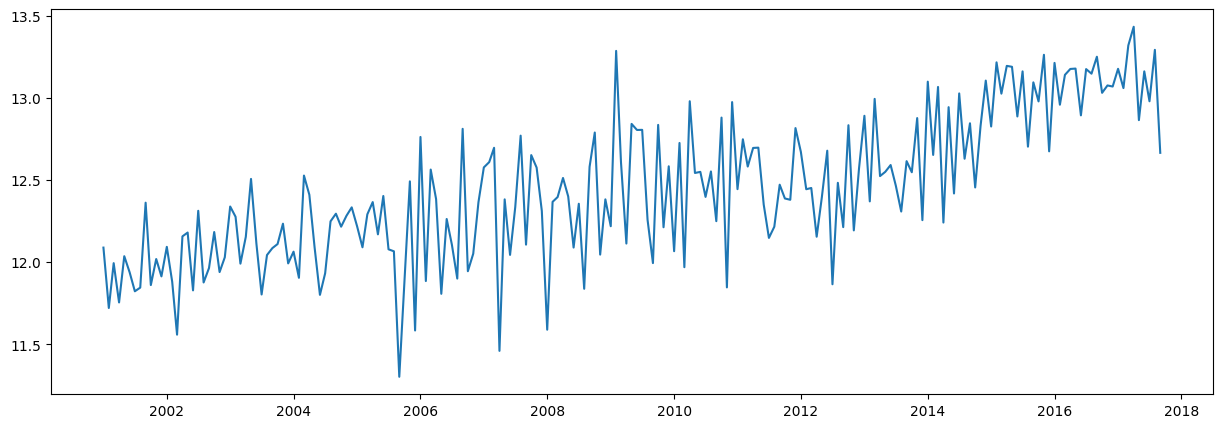

In [65]:
ts_importa_regular_log = np.log(ts_importa_regular)
plt.plot(ts_importa_regular_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la prueba de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [66]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_importa_regular, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.527348
p-value                        0.985681
# de retardos usados          13.000000
# de observaciones usadas    187.000000
Critical Value (1%)           -3.465812
Critical Value (5%)           -2.877123
Critical Value (10%)          -2.575077
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [67]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_importa_regular_diff = ts_importa_regular.diff()
ts_importa_regular_diff.dropna(inplace=True)
dfTest = adfuller(ts_importa_regular_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.850351e+00
p-value                      5.622888e-12
# de retardos usados         9.000000e+00
# de observaciones usadas    1.900000e+02
Critical Value (1%)         -3.465244e+00
Critical Value (5%)         -2.876875e+00
Critical Value (10%)        -2.574945e+00
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

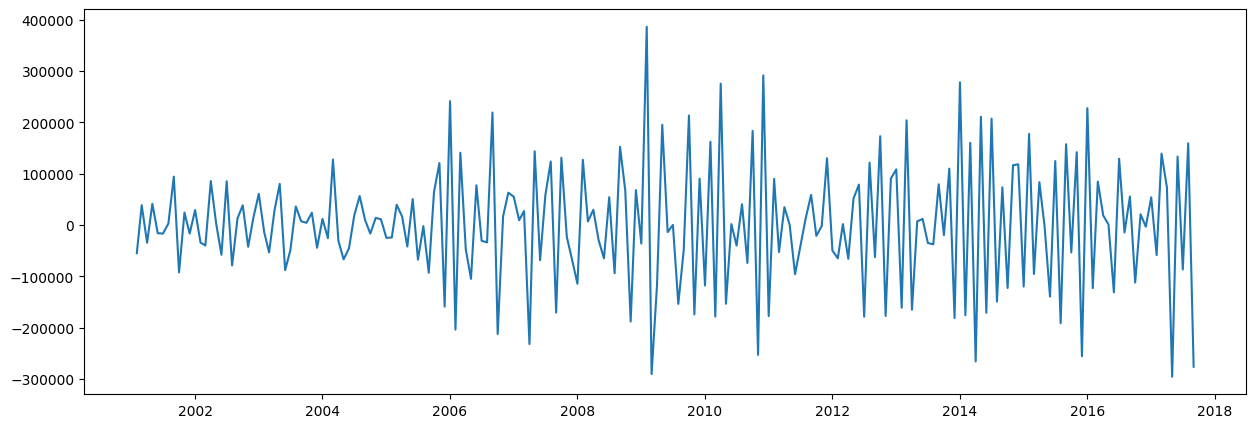

In [68]:
plt.plot(ts_importa_regular_diff)

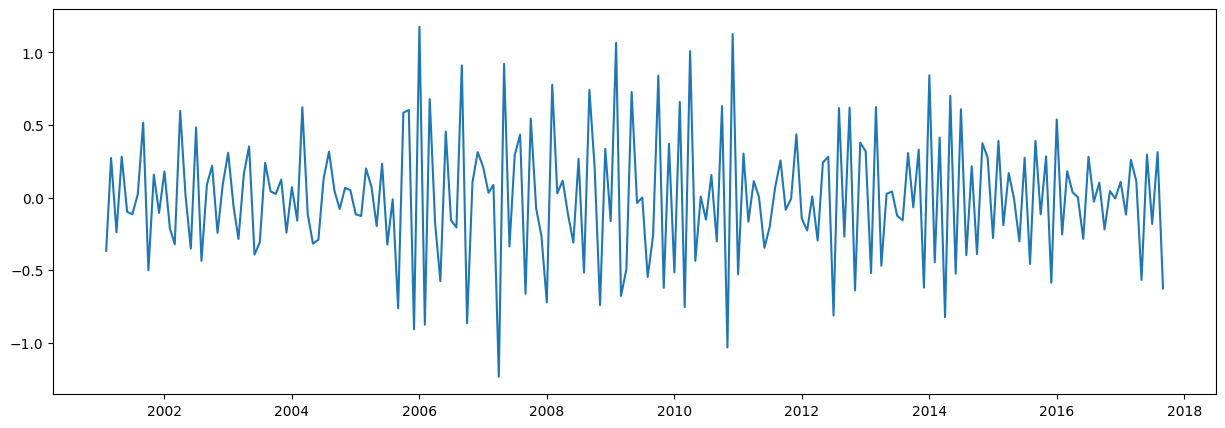

In [69]:
plt.plot(ts_importa_regular_log.diff())

Las transformaciones realizadas fueron una transformación logarítmica y una diferenciación. Se puede ver que la serie ya es estacionaria en media y en varianza. 

#### Estimar los parámetros del modelo

In [70]:
ts_importa_regular_log_diff = ts_importa_regular_log.diff()
ts_importa_regular_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_importa_regular_log_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_importa_regular_log_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.64185905,  0.24424464, -0.1606706 ,  0.05608728,
        0.05465204])

In [71]:
tsa_pacf

array([ 1.        , -0.64508447, -0.29017309, -0.27112663, -0.28057964,
       -0.10134852,  0.0018693 , -0.24878084, -0.07734941, -0.14342956,
       -0.13446501, -0.04074567,  0.08431025, -0.16221139, -0.0378606 ,
        0.05085428,  0.06432559,  0.14870278, -0.12251675, -0.15315643,
        0.00443126,  0.0336349 ,  0.01277527, -0.03243196, -0.01551377,
       -0.09700634,  0.00622242,  0.04346692,  0.07386218, -0.01989149,
        0.20295574, -0.01196702,  0.01277015,  0.06284703, -0.28191063,
        0.13414278, -0.02398083])

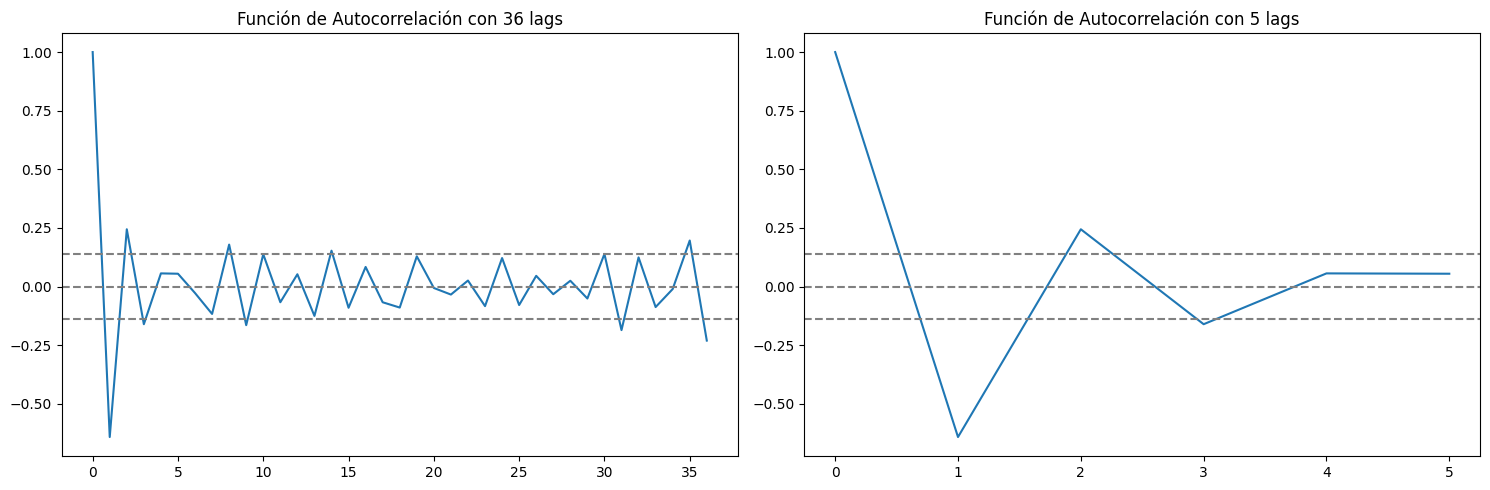

In [72]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_importa_regular_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_importa_regular_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()

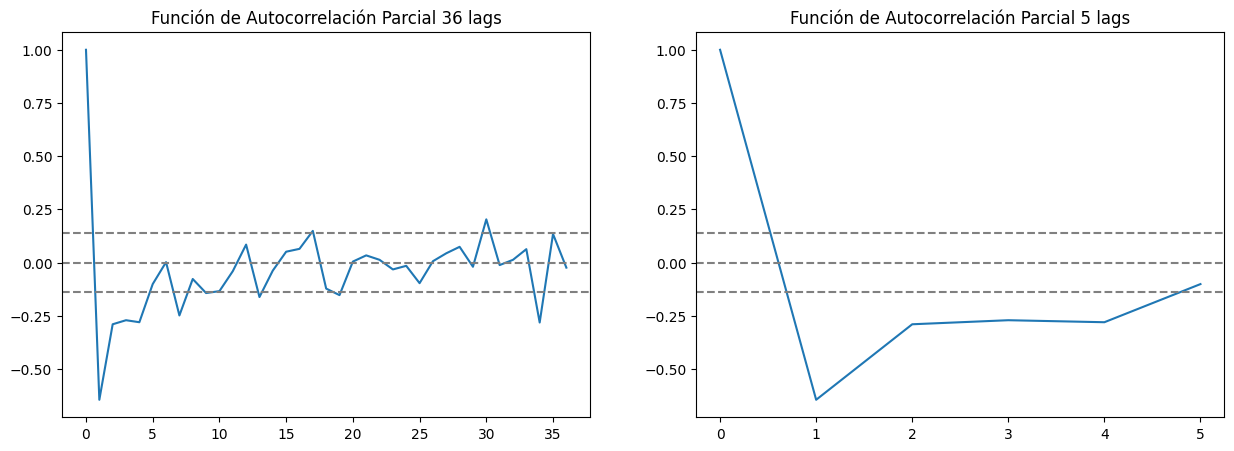

In [73]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_importa_regular_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_importa_regular_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 2
- p = 2, d = 1, q = 3

#### Estacionalidad

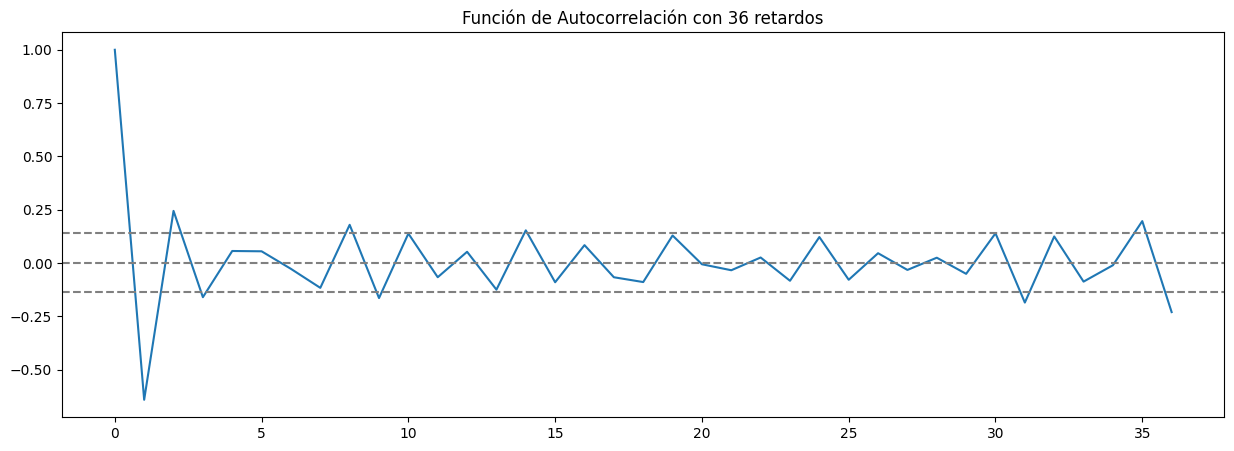

In [74]:
plt.plot(acf(ts_importa_regular_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en el gráfico, el comportamiento es similar para todas las estaciones, no se puede decirque haya estacionalidad cada 12 meses. No es necesario agregar el componente estacional. Se usa solo ARIMA.

#### Generación de modelos

In [75]:
modelo112_IR = ARIMA(ts_importa_regular_log, order=(1,1,2))
resultado_m112_IR = modelo112_IR.fit()
print(resultado_m112_IR.summary().tables[1])

modelo213_IR = ARIMA(ts_importa_regular_log, order=(2,1,3))
resultado_m213_IR = modelo213_IR.fit()
print(resultado_m213_IR.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5656      0.221     -2.563      0.010      -0.998      -0.133
ma.L1         -0.5159      0.246     -2.098      0.036      -0.998      -0.034
ma.L2         -0.2860      0.227     -1.257      0.209      -0.732       0.160
sigma2         0.0817      0.008     10.652      0.000       0.067       0.097
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0846      0.046    -23.746      0.000      -1.174      -0.995
ar.L2         -0.8786      0.053    -16.733      0.000      -0.981      -0.776
ma.L1          0.1607      0.052      3.100      0.002       0.059       0.262
ma.L2          0.0719      0.048      1.499      0.134      -0.022       0.166
ma.L3         -0.8615      0.047    -18.231      0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

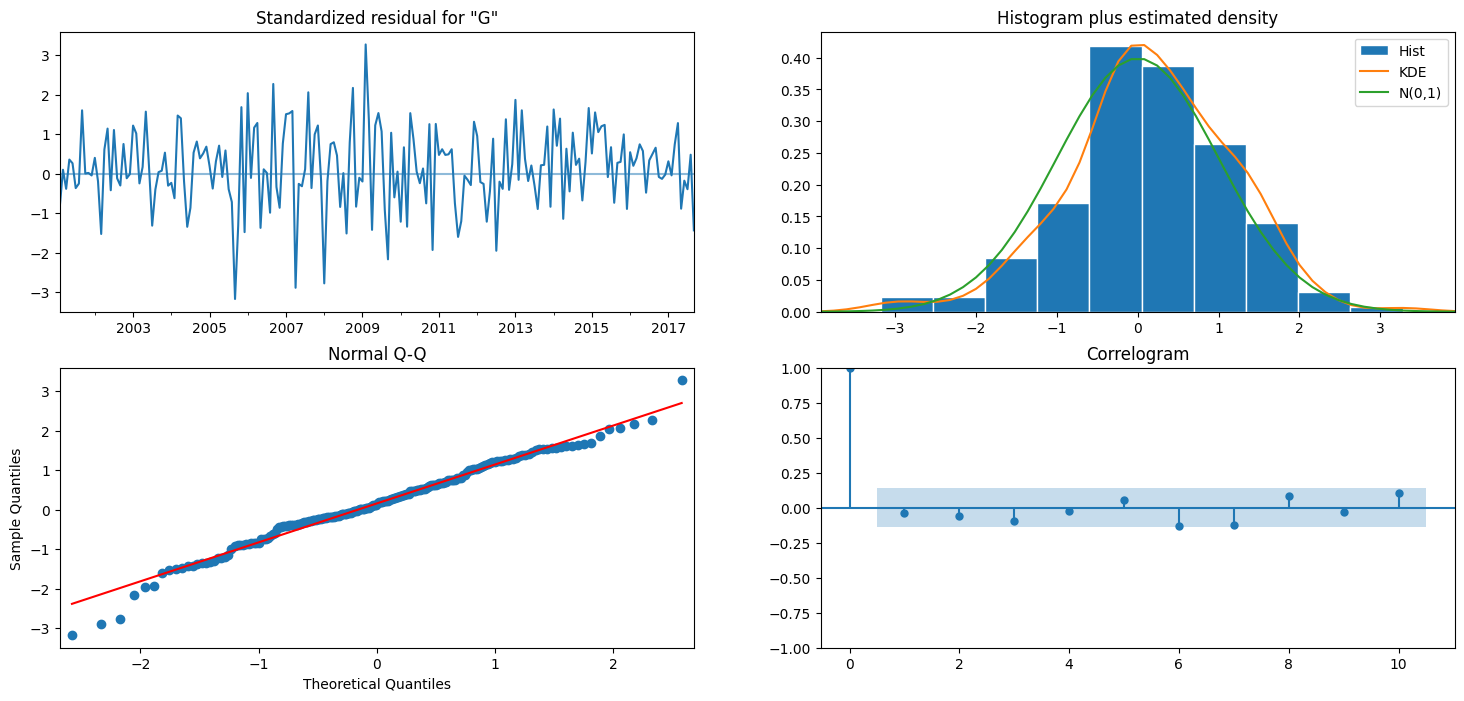

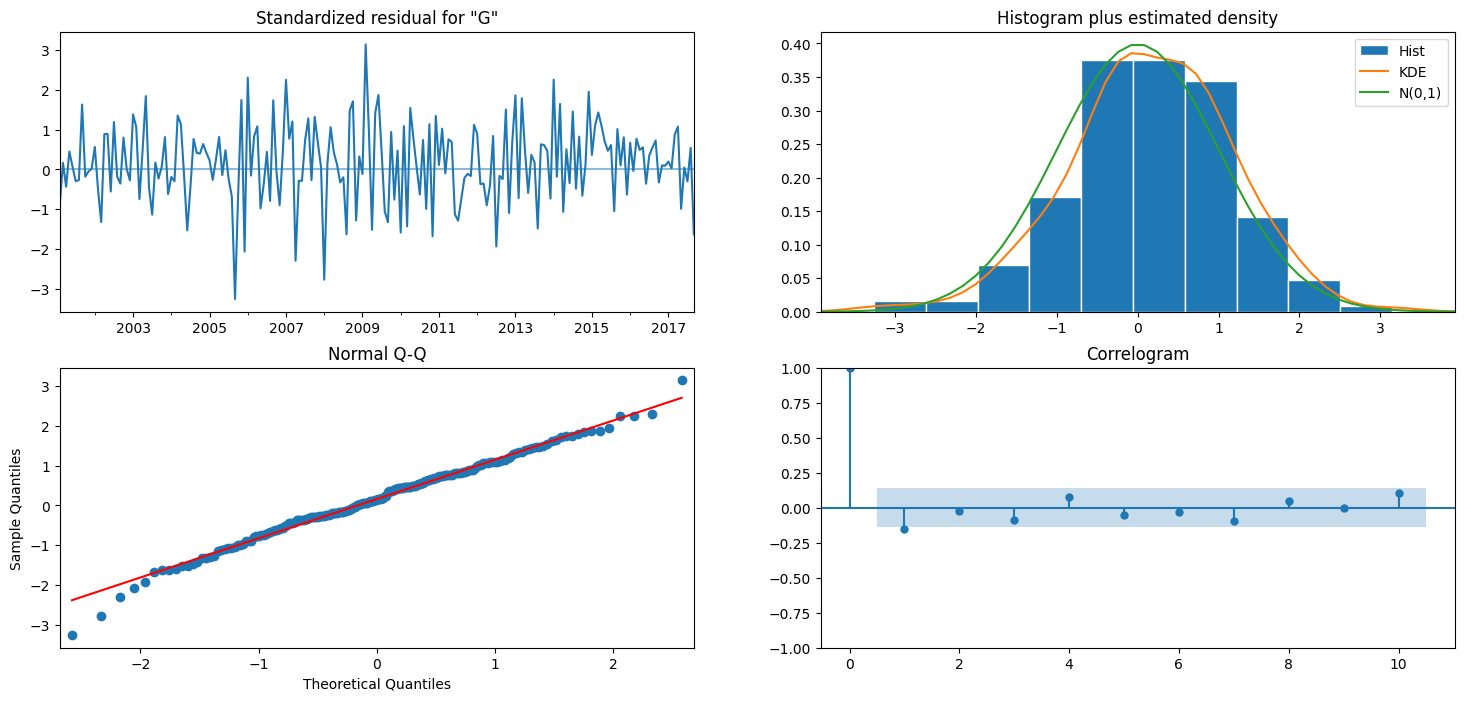

In [76]:
resultado_m112_IR.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m213_IR.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. Aunque el patrón no es claro, se ve varianza más grande al inicio de la serie. 
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control. 

In [77]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 112=",resultado_m112_IR.aic)
print("Modelo 213=",resultado_m213_IR.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 112=",resultado_m112_IR.bic)
print("Modelo 213 =",resultado_m213_IR.bic)


Resultados de AIC (Akaike information criterion)
Modelo 112= 76.40863005209619
Modelo 213= 72.36034565321705
Resultados de BIC (Bayesian information criterion)
Modelo 112= 89.60189951828833
Modelo 213 = 92.15024985250527


De acuerdo a ambos indicadores, el mejor el modelo p = 1, d = 1, q = 2, por lo que este será usado para hacer las predicciones.

### <span style="color: blue;">5. Consumo Diesel</span>

#### Exploración

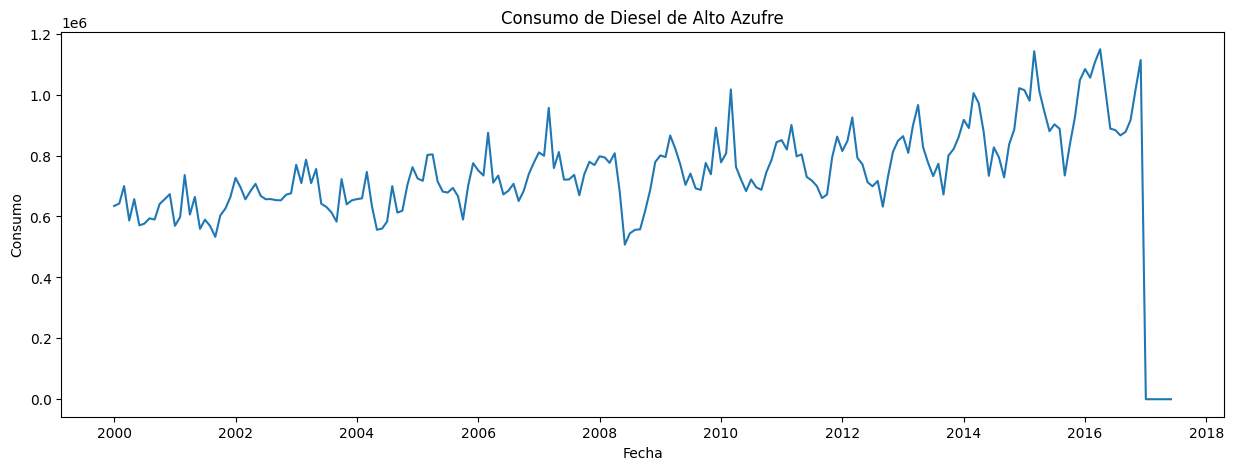

In [78]:
plt.plot(ts_consumo_diesel)
plt.gca().set(title="Consumo de Diesel de Alto Azufre", xlabel="Fecha", ylabel="Consumo")
plt.show()

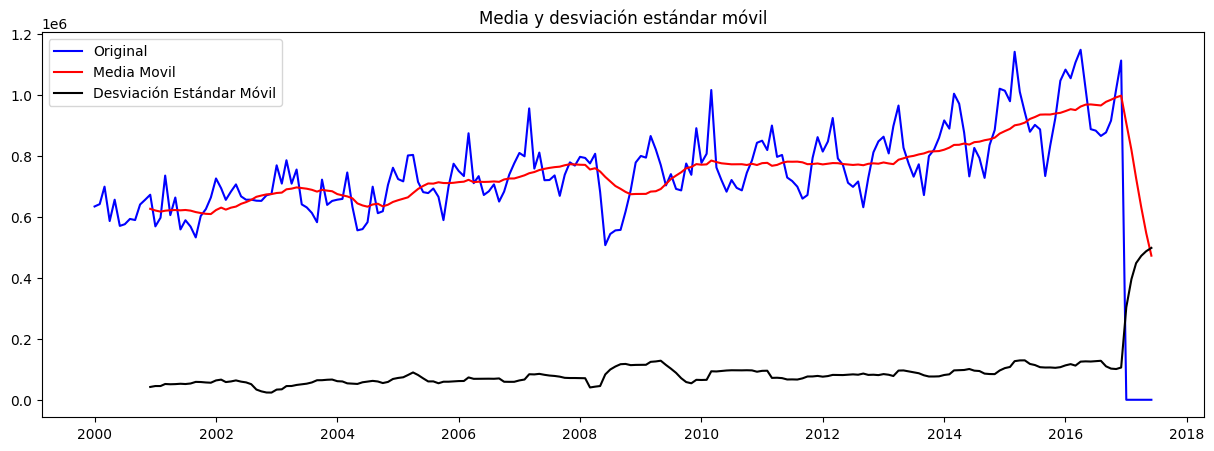

In [79]:
mediaMovil = ts_consumo_diesel.rolling(window=12).mean()
deMovil = ts_consumo_diesel.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_consumo_diesel, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la gráfica de la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. Esto ocurre hasta 2016 donde se va todo a 0.

Por otro lado, la desviación estándar también parece aumentar a lo largo del tiempo, lo que indica que la serie puede no ser estacionaria en varianza. También ocurre que en 2016 se van a 0.

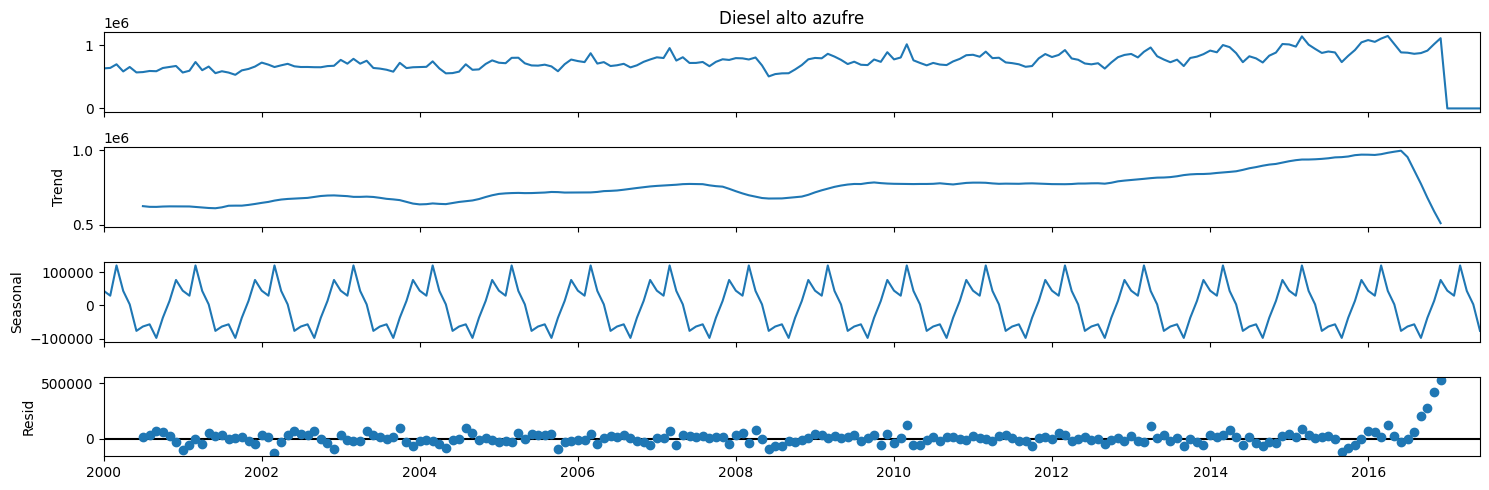

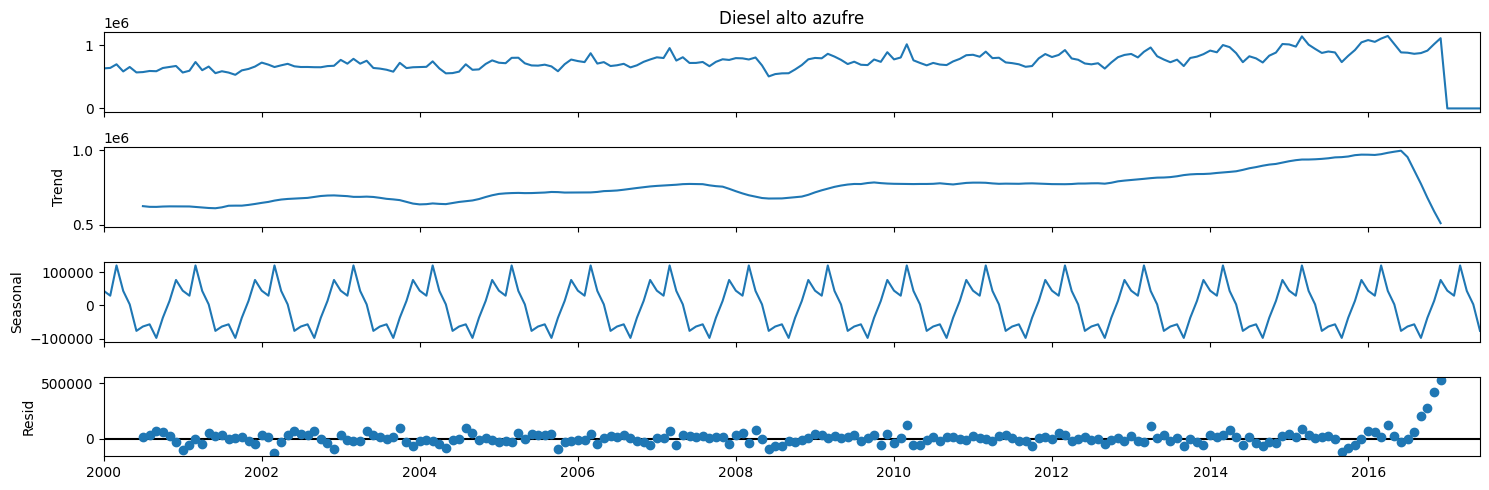

In [80]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_consumo_diesel)
descomposicion.plot()

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece no ser estacionaria, ya que los residuos se dispersan más en el tiempo. 
- Hay estacionalidad clara, lo que sirve para hacer modeos como SARIMA. 
- Será necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


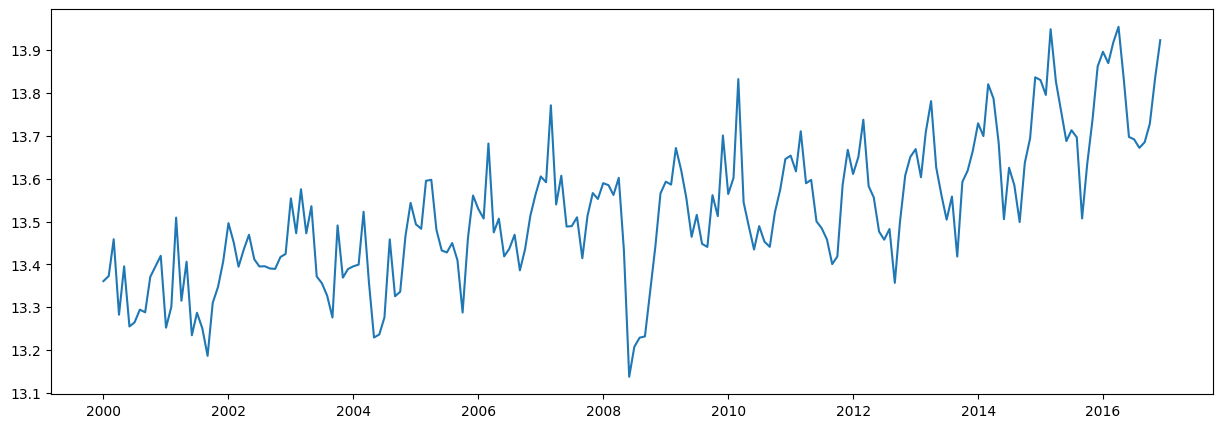

In [81]:
ts_consumo_diesel_log = np.log(ts_consumo_diesel)
plt.plot(ts_consumo_diesel_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la prueba de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [82]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_consumo_diesel, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.644786
p-value                        0.084090
# de retardos usados          12.000000
# de observaciones usadas    197.000000
Critical Value (1%)           -3.463987
Critical Value (5%)           -2.876326
Critical Value (10%)          -2.574652
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [83]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_consumo_diesel_diff = ts_consumo_diesel.diff()
ts_consumo_diesel_diff.dropna(inplace=True)
dfTest = adfuller(ts_consumo_diesel_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.903905e+00
p-value                      4.115217e-12
# de retardos usados         6.000000e+00
# de observaciones usadas    2.020000e+02
Critical Value (1%)         -3.463144e+00
Critical Value (5%)         -2.875957e+00
Critical Value (10%)        -2.574455e+00
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

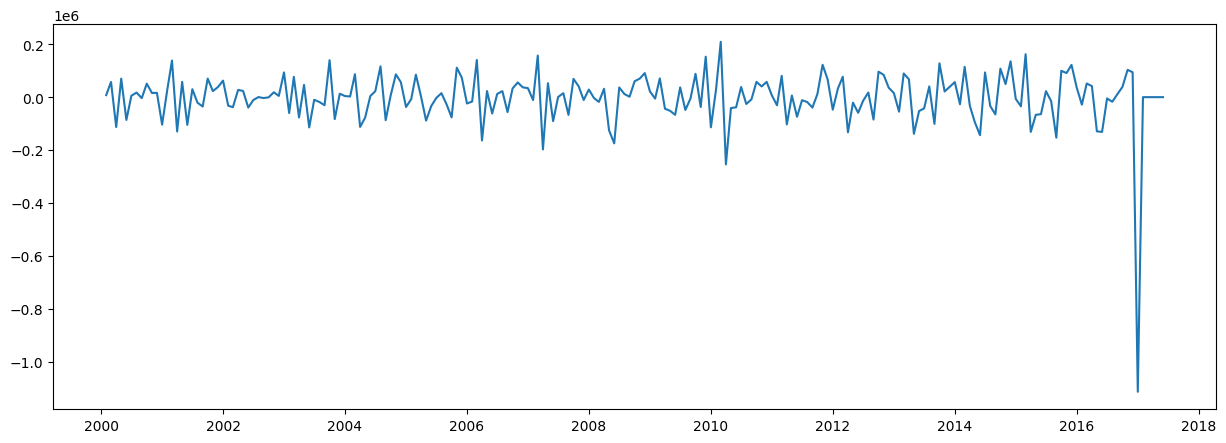

In [84]:
plt.plot(ts_consumo_diesel_diff)

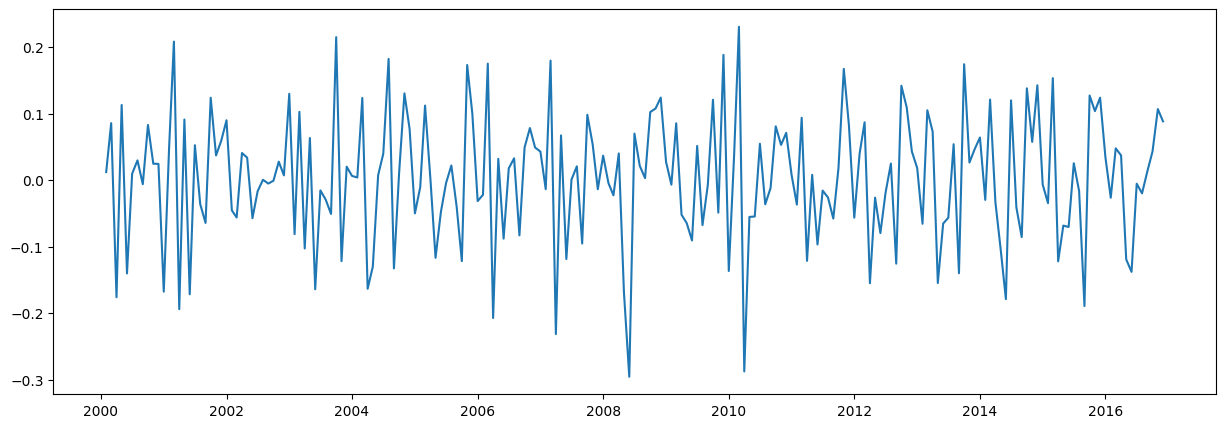

In [85]:
plt.plot(ts_consumo_diesel_log.diff())

Las transformaciones realizadas fueron una transformación logarítmica y una diferenciación. Se puede ver que la serie ya es estacionaria en media y en varianza. 

#### Estimar los parámetros del modelo

In [86]:
ts_consumo_diesel_diff = ts_consumo_diesel.diff()
ts_consumo_diesel_diff.dropna(inplace = True)
tsa_acf = acf(ts_consumo_diesel_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_consumo_diesel_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.13749629, -0.04587267, -0.00178241, -0.04151342,
        0.0162947 ])

In [87]:
tsa_pacf

array([ 1.00000000e+00, -1.38157328e-01, -6.66760071e-02, -1.82741780e-02,
       -4.95067328e-02,  2.26794000e-03, -2.36935043e-01, -5.79845124e-02,
        3.92575779e-02, -6.21588839e-03, -3.87690123e-02,  1.85704086e-03,
        1.97392980e-01,  5.30418694e-04,  2.11559038e-02, -5.78609042e-02,
        5.36542638e-02,  2.27744170e-02, -1.27054231e-01, -1.14047035e-01,
       -1.59883875e-02,  5.77116388e-02, -8.76258157e-02,  5.81282839e-02,
        1.08290119e-01, -1.96489470e-02,  7.20656815e-02, -2.10670034e-02,
       -2.63619932e-02,  5.84631202e-02, -2.03437307e-01,  1.43902193e-02,
        2.38690963e-02, -6.14069497e-02, -2.32820053e-02, -4.84502210e-02,
        8.83186251e-02])

Text(0.5, 1.0, 'Función de Autocorrelación con 5 lags')

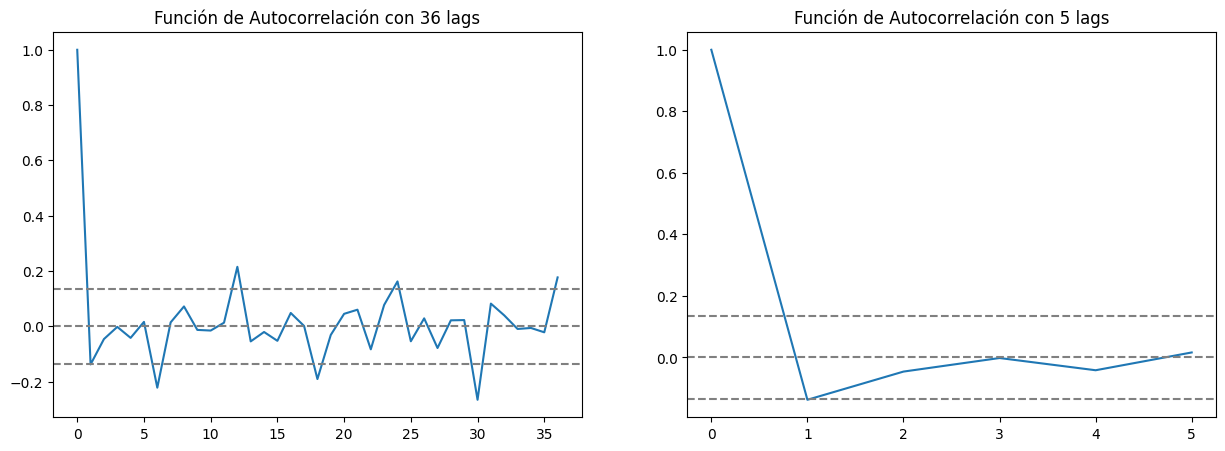

In [88]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_consumo_diesel_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_consumo_diesel_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

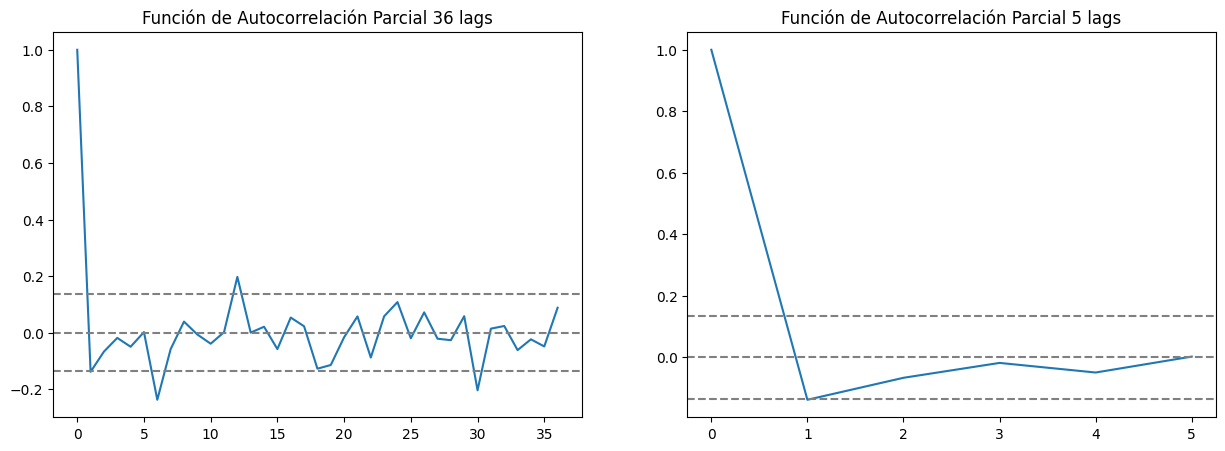

In [89]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_consumo_diesel_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_consumo_diesel_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 1
- p = 2, d = 1, q = 2

#### Estacionalidad

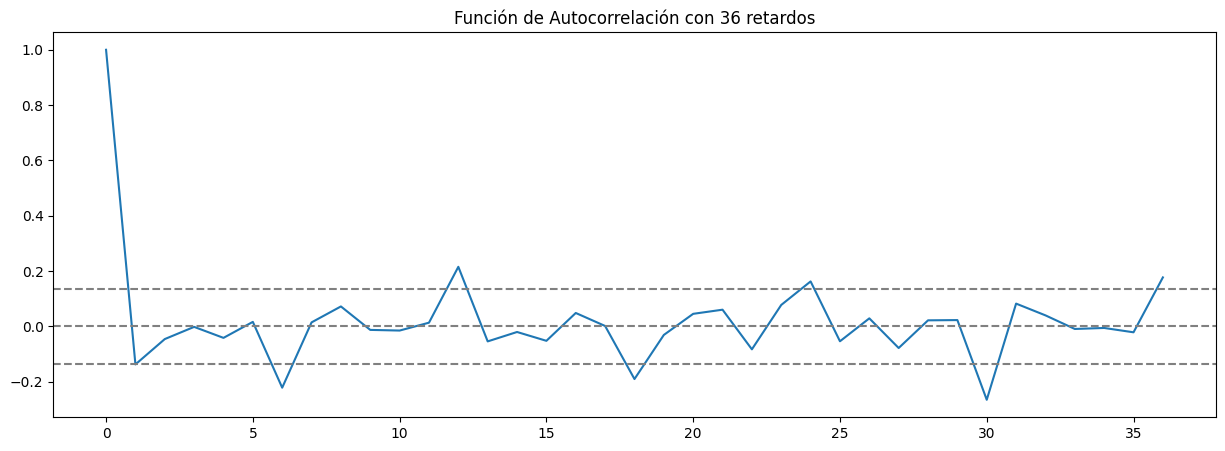

In [90]:
plt.plot(acf(ts_consumo_diesel_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar para 12, 24, 36 meses por lo que hay una correlación entre los años, eso indica que hay estacionalidad cada 12 meses. Por lo tanto se le agrega el componente estacional. 

In [91]:
ts_consumo_diesel_D = ts_consumo_diesel.diff(12)
ts_consumo_diesel_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 lags')

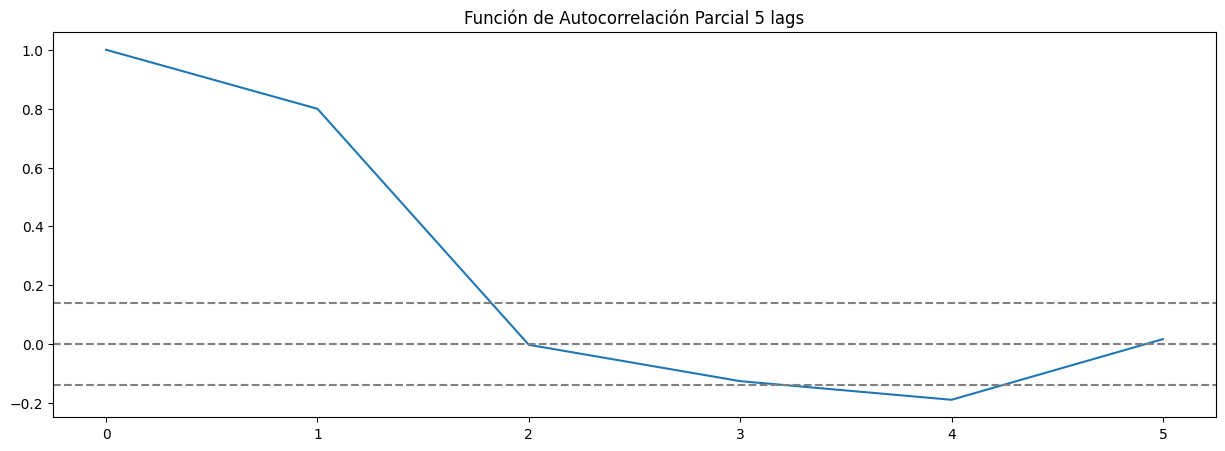

In [92]:

plt.plot(pacf(ts_consumo_diesel_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_diesel_D)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_diesel_D)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=1. Se probara el siguiente componenete estacional:
- P = 1
- D = 1
- Q = 0

In [93]:
modelo111_DC = SARIMAX(ts_consumo_diesel, order=(1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111_DC = modelo111_DC.fit()
print(resultado_m111_DC  .summary().tables[1])

modelo212_DC = SARIMAX(ts_consumo_diesel, order=(2,1,2), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m212_DC = modelo212_DC.fit()
print(resultado_m212_DC.summary().tables[1])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1262      0.489     -0.258      0.796      -1.084       0.832
ma.L1         -0.0546      0.485     -0.113      0.910      -1.006       0.897
ar.S.L12      -0.4551      0.157     -2.899      0.004      -0.763      -0.147
sigma2      1.201e+10   2.01e-10   5.96e+19      0.000     1.2e+10     1.2e+10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0697      0.307     -3.486      0.000      -1.671      -0.468
ar.L2         -0.6972      0.437     -1.595      0.111      -1.554       0.160
ma.L1          0.9036      0.330      2.742      0.006       0.258       1.550
ma.L2          0.5655      0.500      1.132      0.258      -0.414       1.545
ar.S.L12      -0.4246      0.189     -2.242      0.0

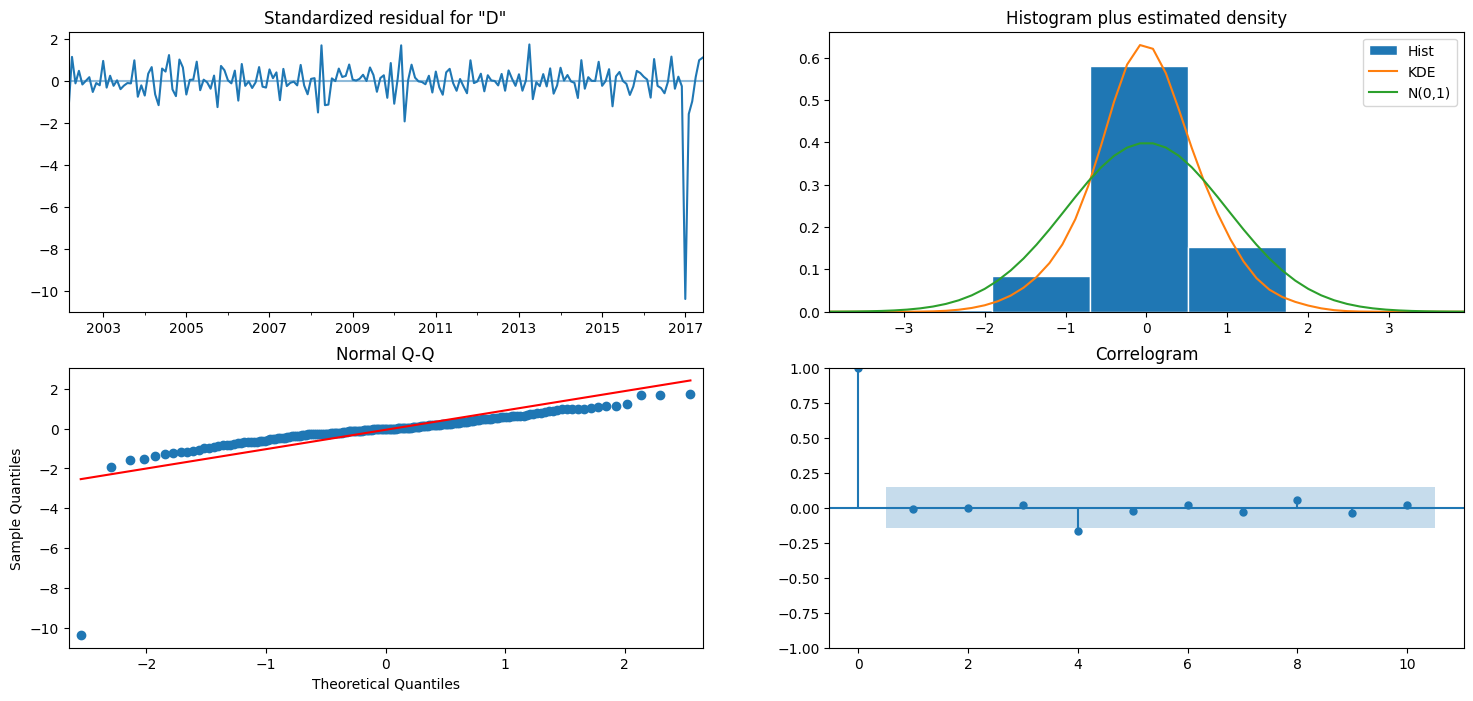

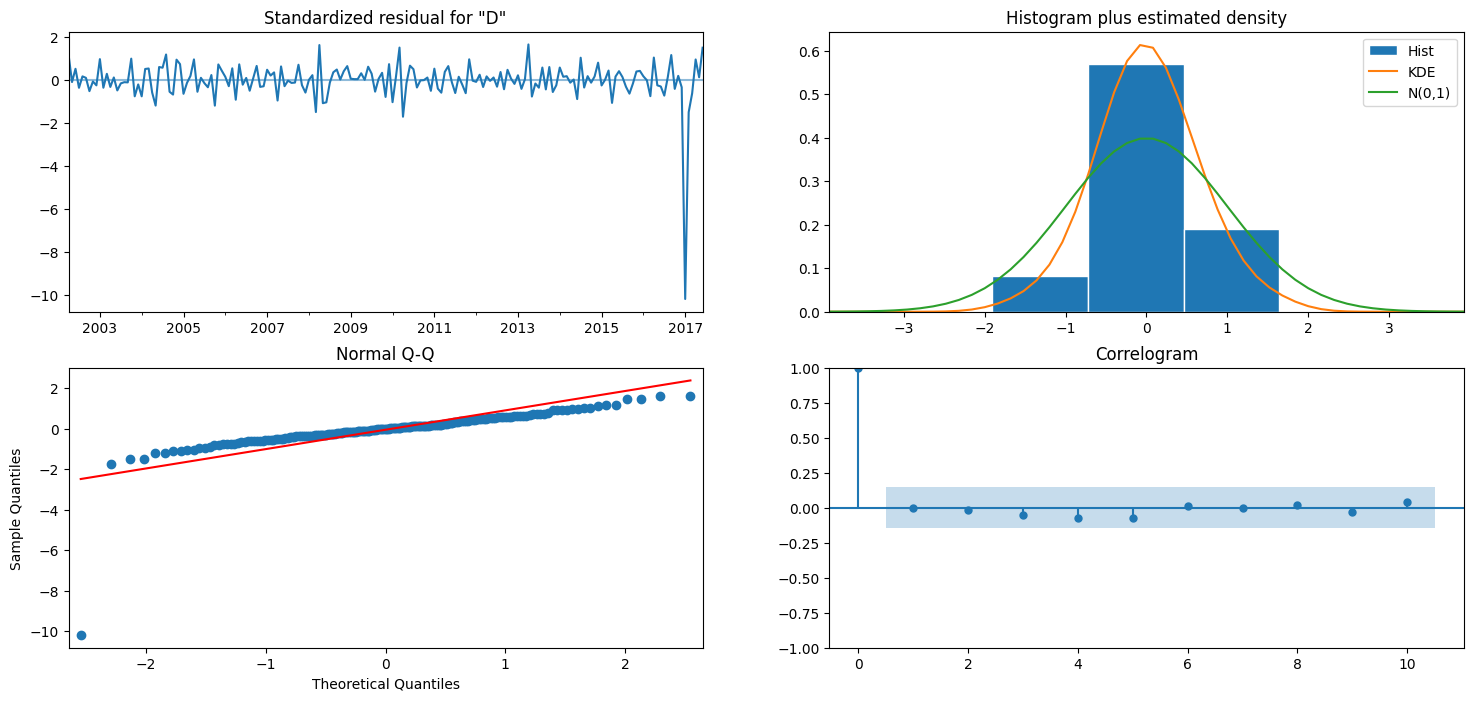

In [94]:
resultado_m111_DC.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m212_DC.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. La varianza es constante.
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control la mayoría de casos. 

In [95]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111_DC.aic)
print("Modelo 212=",resultado_m212_DC.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111_DC.bic)
print("Modelo 212 =",resultado_m212_DC.bic)


Resultados de AIC (Akaike information criterion)
Modelo 111= 4791.47954421147
Modelo 212= 4765.651627615696
Resultados de BIC (Bayesian information criterion)
Modelo 111= 4804.339287241906
Modelo 212 = 4784.908544532745


De acuerdo a ambos indicadores, el mejor el modelo p = 2, d = 1, q = 2, aunque la diferencia es mínima. Este será usado para hacer las predicciones.

### <span style="color: blue;">6. Importaciones Diesel</span>

#### Exploración

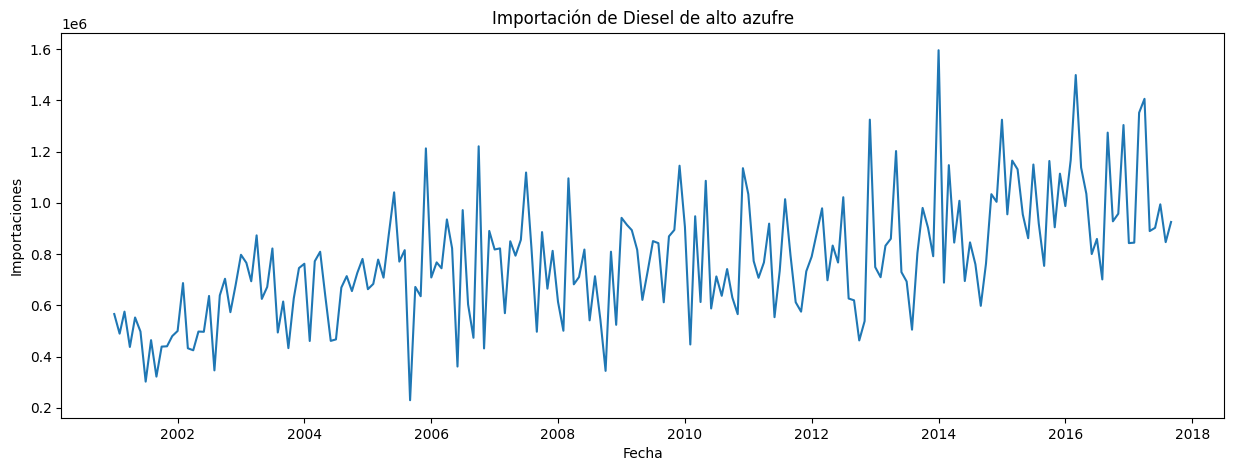

In [96]:
plt.plot(ts_importa_diesel)
plt.gca().set(title="Importación de Diesel de alto azufre", xlabel="Fecha", ylabel="Importaciones")
plt.show()

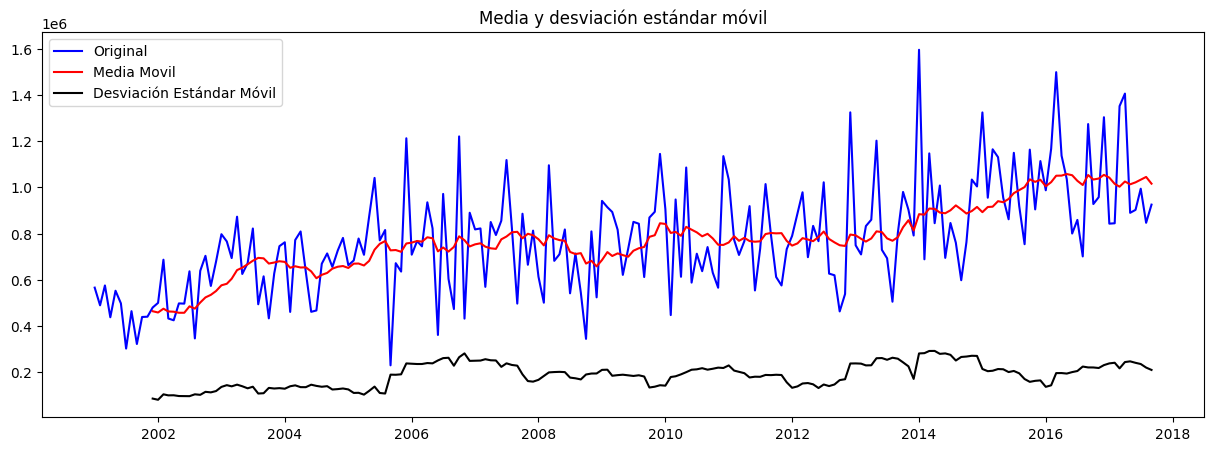

In [97]:
mediaMovil = ts_importa_diesel.rolling(window=12).mean()
deMovil = ts_importa_diesel.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_importa_diesel, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la gráfica de la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar no parece aumentar a lo largo del tiempo, lo que indica que la serie puede ser estacionaria en varianza.

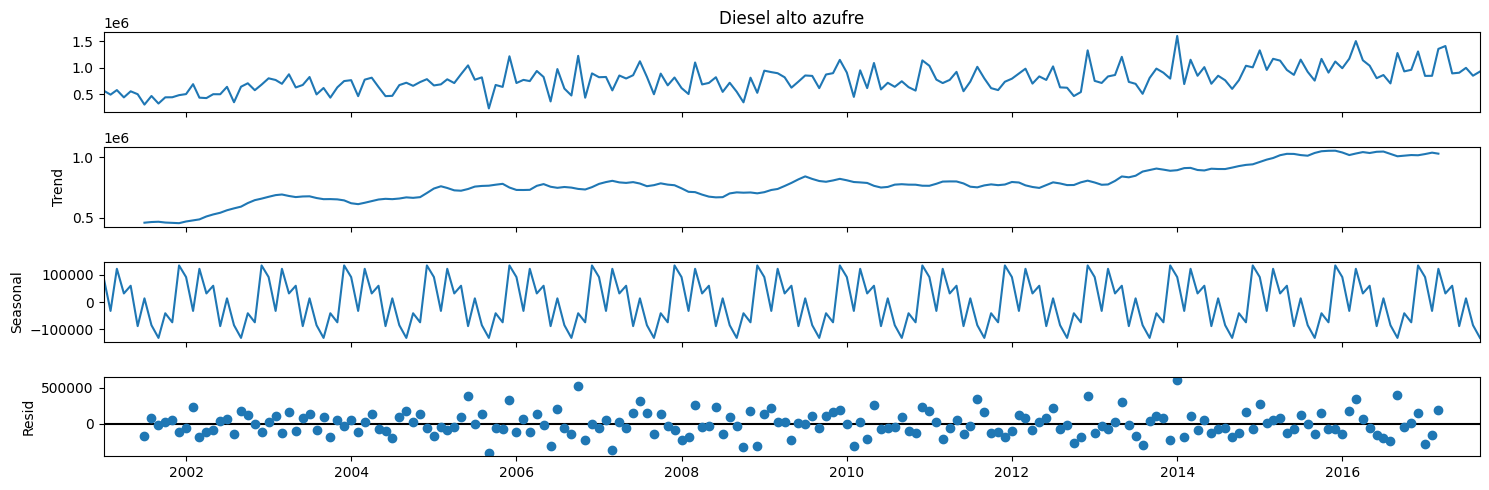

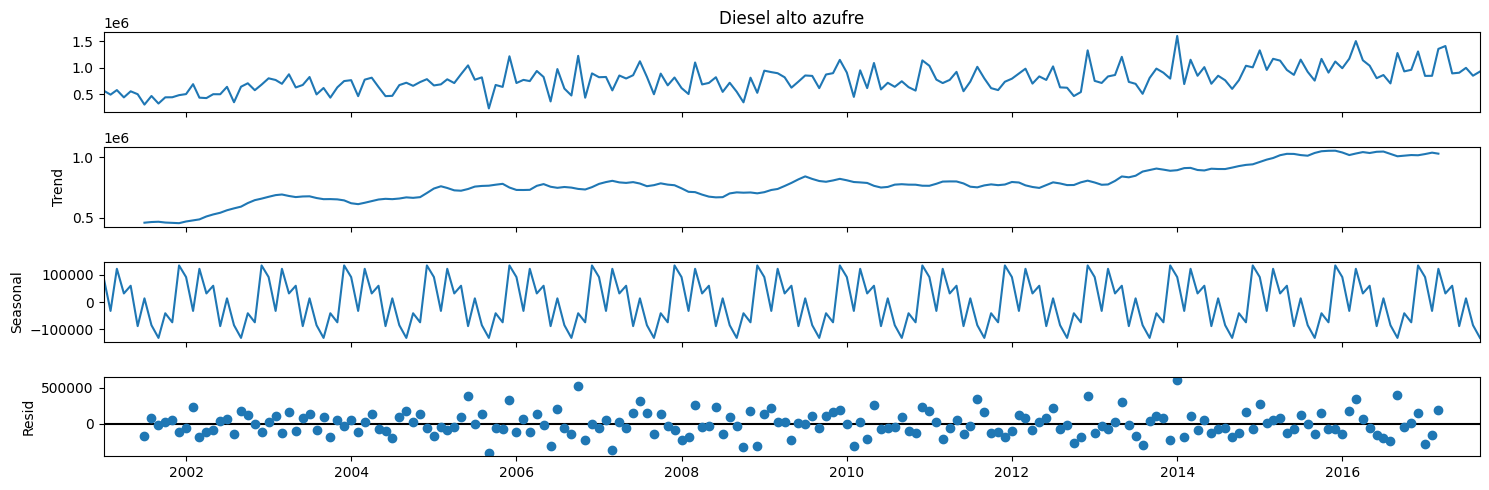

In [98]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_importa_diesel)
descomposicion.plot()

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece ser estacionaria, ya que los residuos no se dispersan tanto con el tiempo.
- Hay estacionalidad clara, lo que sirve para hacer modelos como SARIMA. 
- Será necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

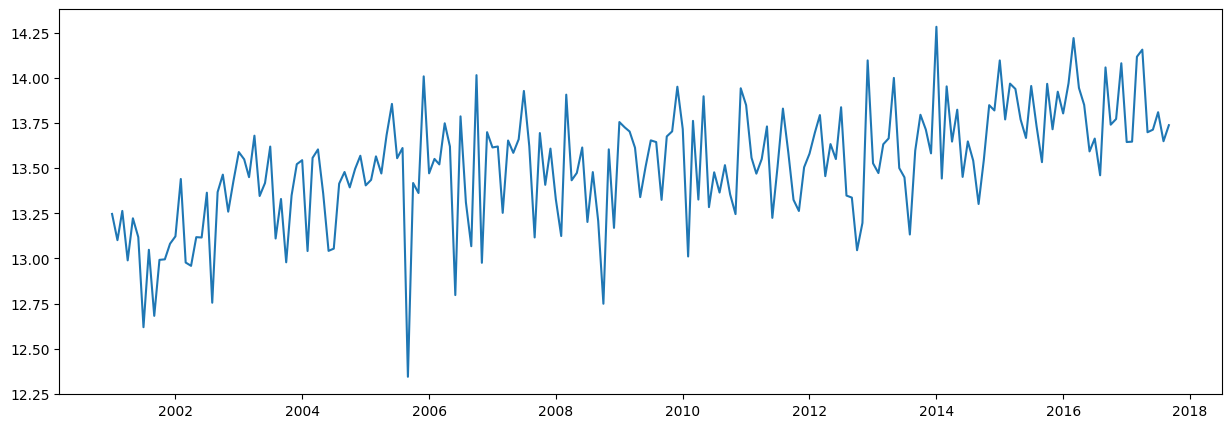

In [99]:
ts_importa_diesel_log = np.log(ts_importa_diesel)
plt.plot(ts_importa_diesel_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la prueba de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [100]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_importa_diesel, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.545176
p-value                        0.511057
# de retardos usados          13.000000
# de observaciones usadas    187.000000
Critical Value (1%)           -3.465812
Critical Value (5%)           -2.877123
Critical Value (10%)          -2.575077
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [101]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_importa_diesel_diff = ts_importa_diesel.diff()
ts_importa_diesel_diff.dropna(inplace=True)
dfTest = adfuller(ts_importa_diesel_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.564851e+00
p-value                      2.944191e-11
# de retardos usados         1.200000e+01
# de observaciones usadas    1.870000e+02
Critical Value (1%)         -3.465812e+00
Critical Value (5%)         -2.877123e+00
Critical Value (10%)        -2.575077e+00
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

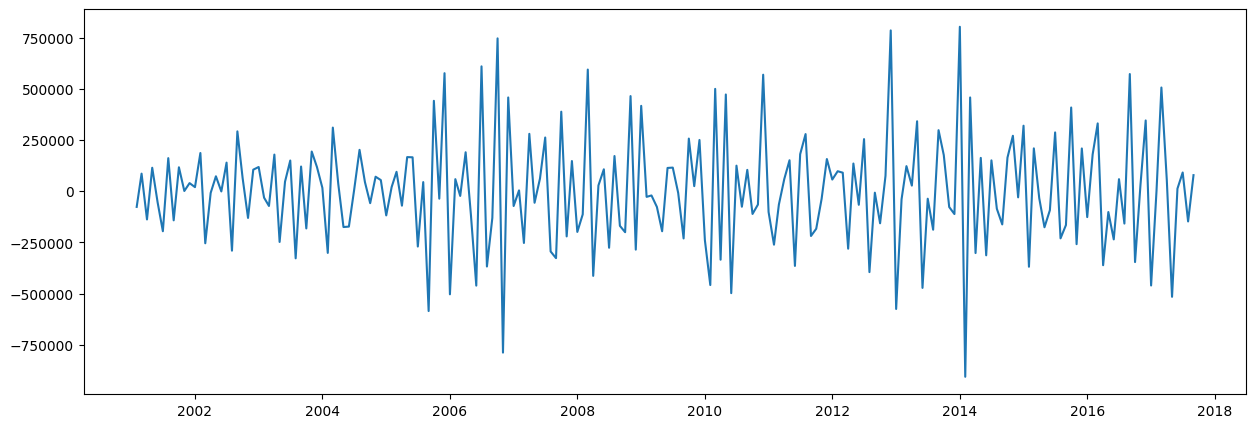

In [102]:
plt.plot(ts_importa_diesel_diff)

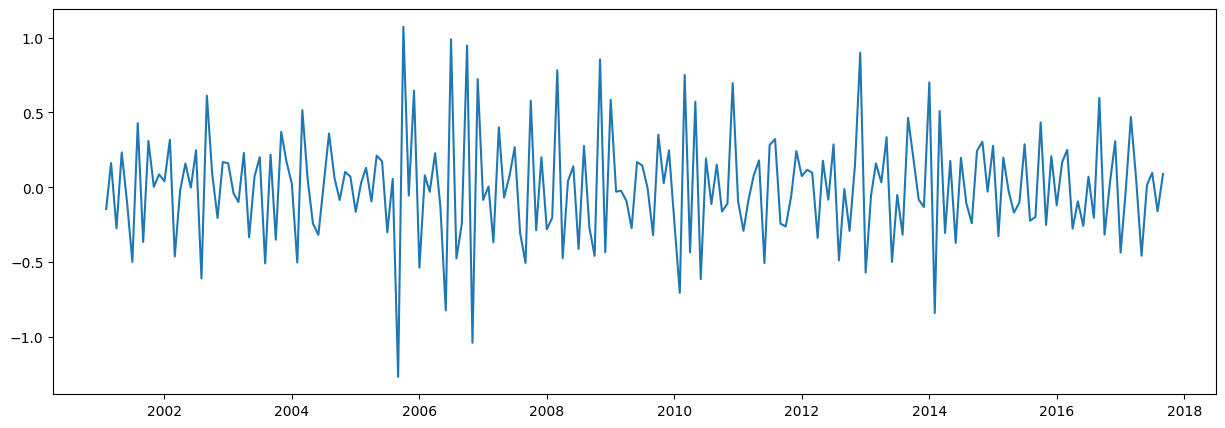

In [103]:
plt.plot(ts_importa_diesel_log.diff())

Las transformaciones realizadas fueron una transformación logarítmica y una diferenciación. Se puede ver que la serie ya es estacionaria en media y en varianza. 

#### Estimar los parámetros del modelo

In [104]:
ts_importa_diesel_diff = ts_importa_diesel.diff()
ts_importa_diesel_diff.dropna(inplace = True)
tsa_acf = acf(ts_importa_diesel_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_importa_diesel_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.53057582,  0.06010013, -0.01011069, -0.05364869,
        0.08970995])

In [105]:
tsa_pacf

array([ 1.        , -0.53324204, -0.31249766, -0.20814638, -0.2359597 ,
       -0.10386916, -0.12314787, -0.1500596 , -0.22103995, -0.20005425,
       -0.10836904, -0.22429594, -0.10799065, -0.17636071, -0.03688216,
       -0.07314562,  0.03398455,  0.04916604,  0.01867442, -0.10650147,
        0.02292203, -0.01554489, -0.16223549, -0.17218918, -0.19204375,
       -0.15976935, -0.12942283, -0.19473026, -0.17317202, -0.08431728,
       -0.06868148, -0.05508016, -0.06996913, -0.07262639, -0.11162807,
       -0.21690906, -0.17230439])

Text(0.5, 1.0, 'Función de Autocorrelación con 5 lags')

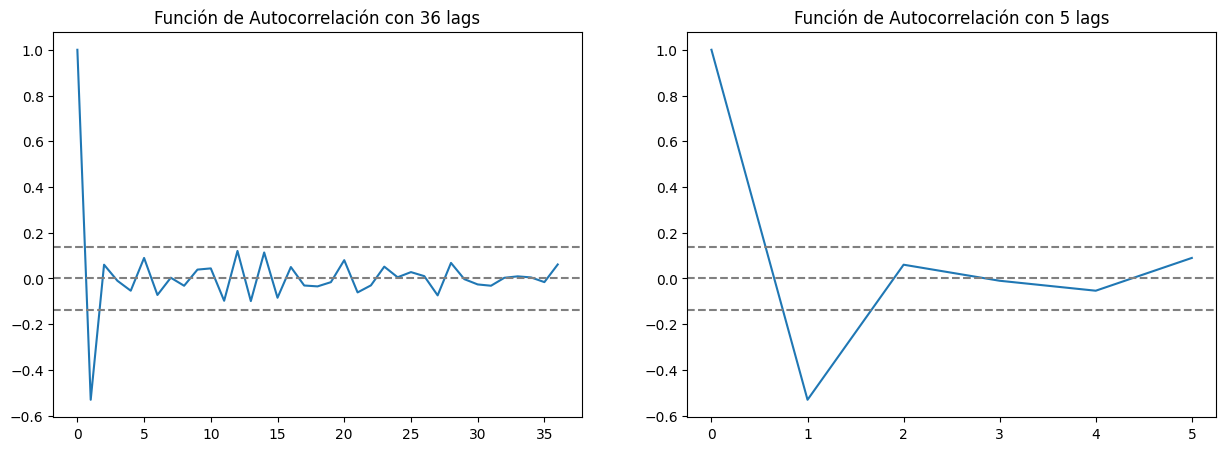

In [106]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_importa_diesel_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_importa_diesel_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

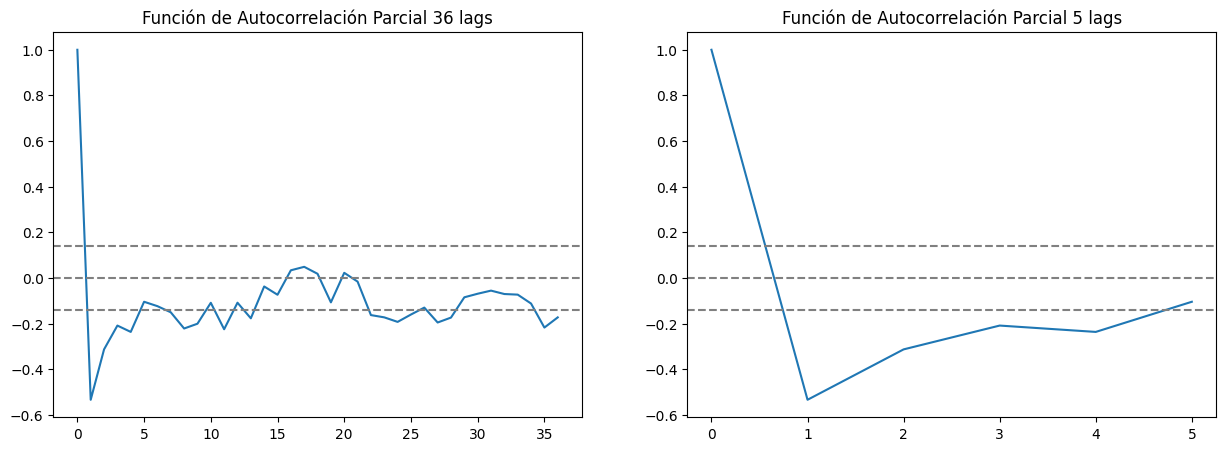

In [107]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_importa_diesel_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_importa_diesel_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 1
- p = 2, d = 1, q = 2

#### Estacionalidad

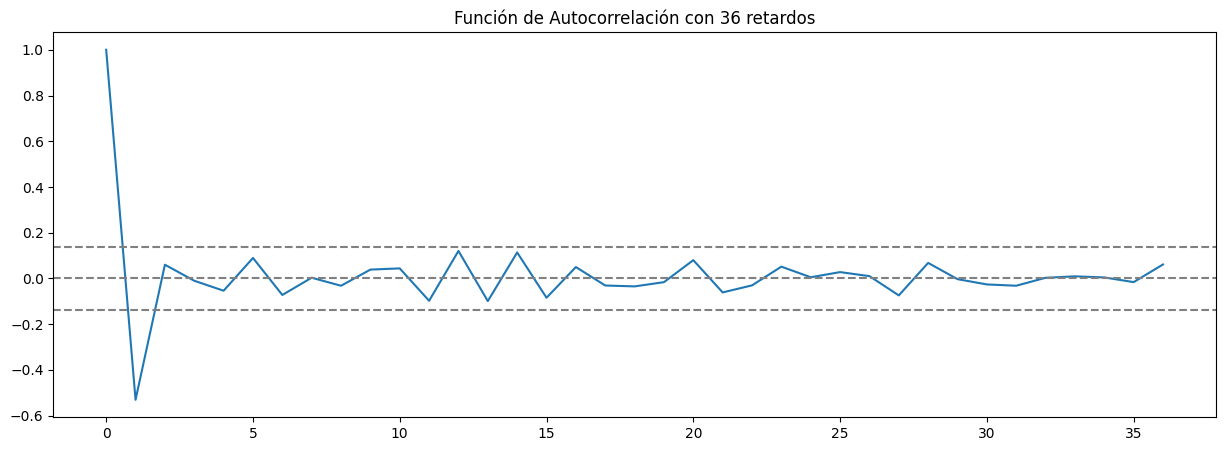

In [108]:
plt.plot(acf(ts_importa_diesel_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_diesel_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en el gráfico, el comportamiento es similar para todas las estaciones, no se puede decirque haya estacionalidad cada 12 meses. No es necesario agregar el componente estacional. Se usa solo ARIMA.

#### Generación de modelos

In [109]:
modelo111_ID = ARIMA(ts_importa_diesel, order=(1,1,1))
resultado_m111_ID = modelo111_ID.fit()
print(resultado_m111_ID.summary().tables[1])

modelo212_ID = ARIMA(ts_importa_diesel, order=(2,1,2))
resultado_m212_ID = modelo212_ID.fit()
print(resultado_m212_ID.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0379      0.102     -0.370      0.712      -0.239       0.163
ma.L1         -0.8961      0.044    -20.544      0.000      -0.982      -0.811
sigma2      4.783e+10   1.71e-13    2.8e+23      0.000    4.78e+10    4.78e+10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8138     21.071     -0.039      0.969     -42.112      40.485
ar.L2         -0.0304      0.766     -0.040      0.968      -1.533       1.472
ma.L1         -0.1204     21.069     -0.006      0.995     -41.415      41.174
ma.L2         -0.6954     18.884     -0.037      0.971     -37.708      36.317
sigma2      4.518e+10   3.74e-08   1.21e+18      0.000    4.52e+10    4.52e+10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

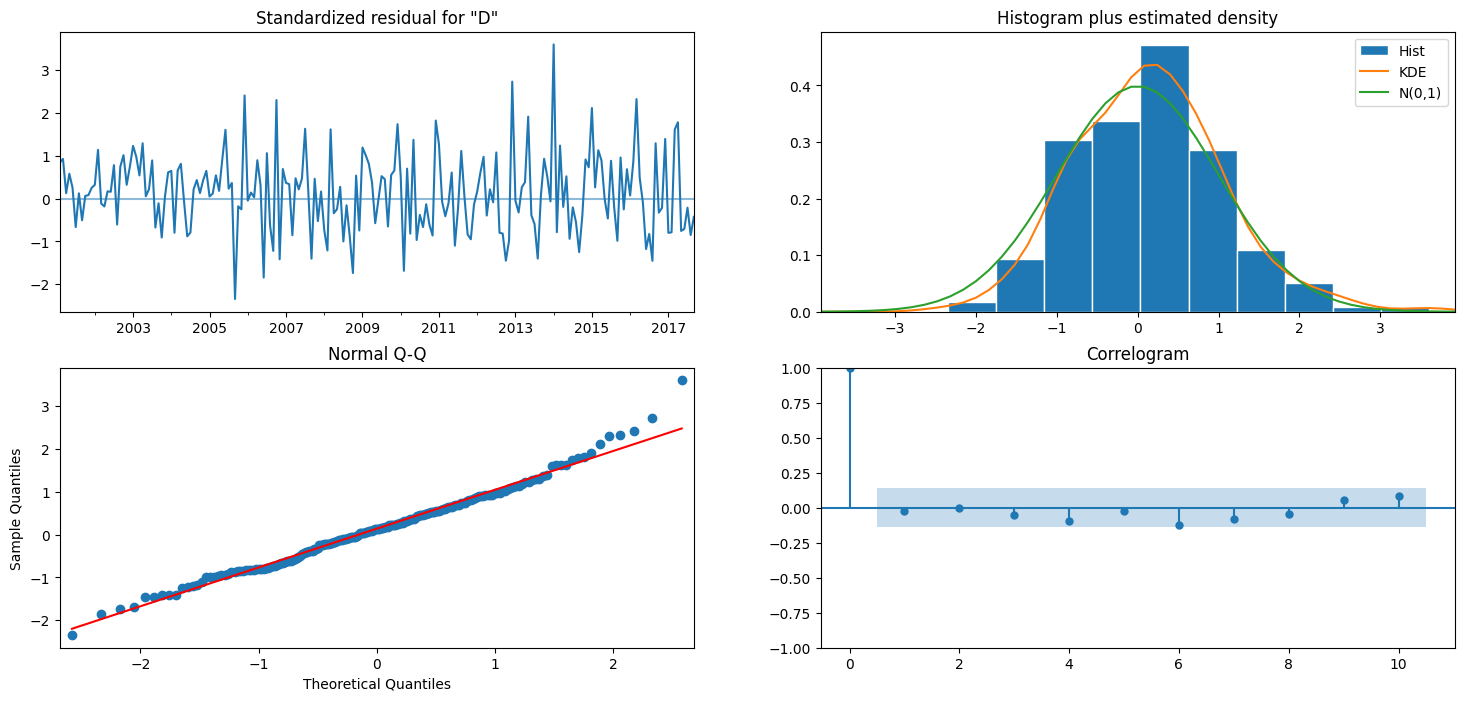

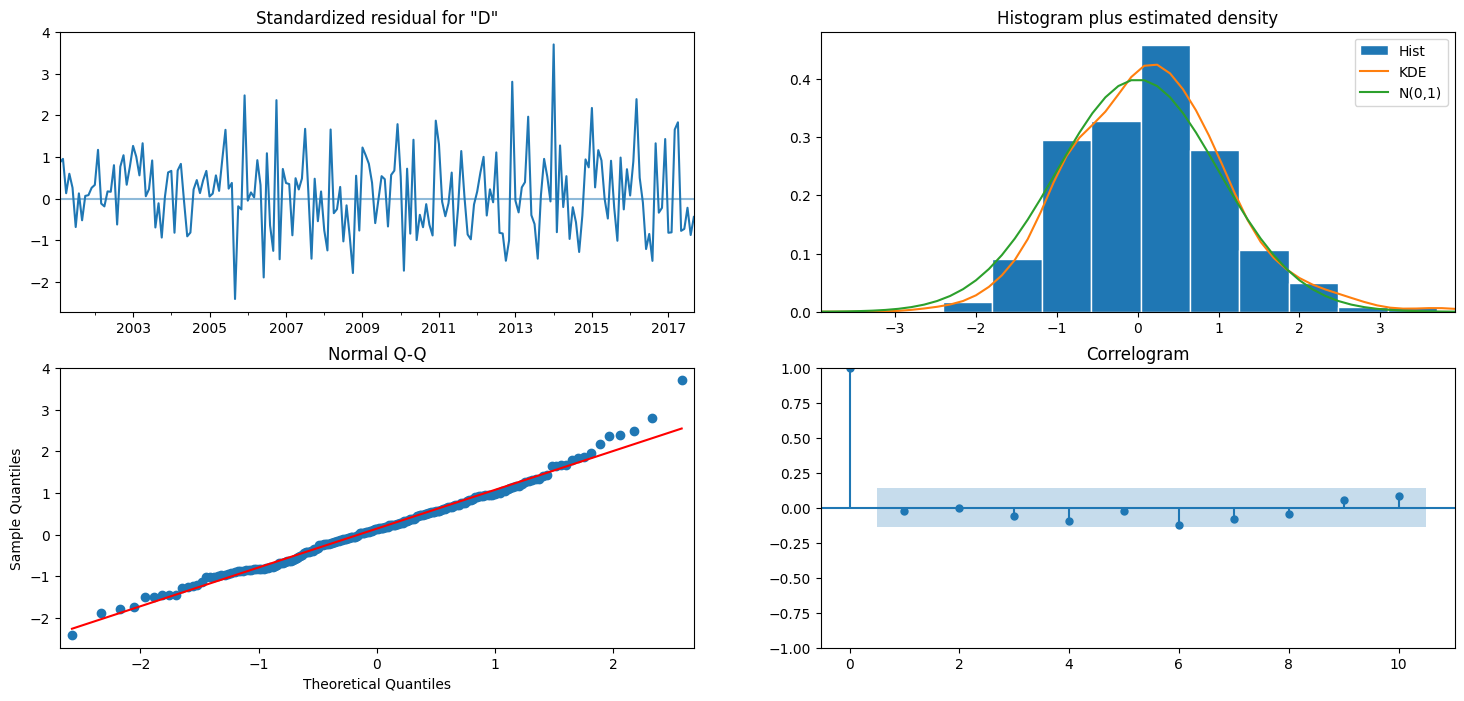

In [110]:
resultado_m111_ID.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m212_ID.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. La varianza es constante.
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control la mayoría de casos. 

In [111]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111_ID.aic)
print("Modelo 212=",resultado_m212_ID.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111_ID.bic)
print("Modelo 212 =",resultado_m212_ID.bic)


Resultados de AIC (Akaike information criterion)
Modelo 111= 5461.168800567488
Modelo 212= 5463.644101013961
Resultados de BIC (Bayesian information criterion)
Modelo 111= 5471.063752667132
Modelo 212 = 5480.1356878467


De acuerdo a ambos indicadores, el mejor el modelo p = 1, d = 1, q = 1, aunque la diferencia es mínima. Este será usado para hacer las predicciones.

## Predicciones y Evaluación de modelos

In [153]:
def calcular_metricas(y_true, y_pred, nombre_modelo):
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100    
    bias = np.mean(y_pred - y_true)
    std_error = np.std(y_true - y_pred)
    
    metricas = {
        'Modelo': nombre_modelo,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'BIAS': bias,
        'STD_ERROR': std_error,
        'MSE': mse
    }
    
    return metricas

### <span style="color: blue;">1. Consumo Gasolina Superior</span>

#### Predicciones

In [159]:
# Predicciones modelo 113
pred_113_cs = resultado_m113_CS.forecast(steps=90)
pred_113_cs_ci = resultado_m113_CS.get_forecast(steps=90).conf_int()

# Predicciones modelo 214
pred_214_cs = resultado_m214_CS.forecast(steps=90)
pred_214_cs_ci = resultado_m214_CS.get_forecast(steps=90).conf_int()

# Crear fechas futuras para Prophet 
futuro_prophet_cs = modelo_prophet_cs.make_future_dataframe(periods=90, freq='M')
forecast_prophet_cs = modelo_prophet_cs.predict(futuro_prophet_cs)

# Extraer solo las predicciones futuras (últimas 90)
pred_prophet_cs = forecast_prophet_cs['yhat'].tail(90).values
pred_prophet_bajo_cs = forecast_prophet_cs['yhat_lower'].tail(90).values
pred_prophet_alto_cs = forecast_prophet_cs['yhat_upper'].tail(90).values

/Users/arielamishaancohen/Library/Python/3.13/lib/python/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


#### Métricas

In [160]:
y_test = ts_consumo_superior_test.values if hasattr(ts_consumo_superior_test, 'values') else ts_consumo_superior_test

# Calcular métricas para cada modelo
metricas_113_cs = calcular_metricas(y_test, pred_113_cs, 'SARIMAX (1,1,3)(3,1,0,12)')
metricas_214_cs = calcular_metricas(y_test, pred_214_cs, 'SARIMAX (2,1,4)(3,1,0,12)')
metricas_prophet_cs = calcular_metricas(y_test, pred_prophet_cs, 'Prophet')

# Crear DataFrame con todas las métricas
df_metricas = pd.DataFrame([metricas_113_cs, metricas_214_cs, metricas_prophet_cs])

print(df_metricas)

                      Modelo        R²           RMSE            MAE  \
0  SARIMAX (1,1,3)(3,1,0,12) -3.124984  141908.702803  115550.600320   
1  SARIMAX (2,1,4)(3,1,0,12) -3.640167  150509.782083  124421.983109   
2                    Prophet -5.765893  181744.161666  154737.404962   

        MAPE           BIAS     STD_ERROR           MSE  
0  19.986050  114456.058274  83892.137031  2.013808e+10  
1  21.444482  123568.203284  85930.749094  2.265319e+10  
2  26.451668  154392.920659  95884.129814  3.303094e+10  


Se puede ver que los tres modelos tienen un rendimiento similar en todas las métricas que se muestran. La métrica que escogimos para evaluar y comparar es el **MAPE**, el error porcentual absoluto medio. Se observa que el modelo con un error menor es el **modelo SARIMAX con parámetros 113**. Este es el que se utilizará para hacer las predicciones del 2025.

#### Gráfica

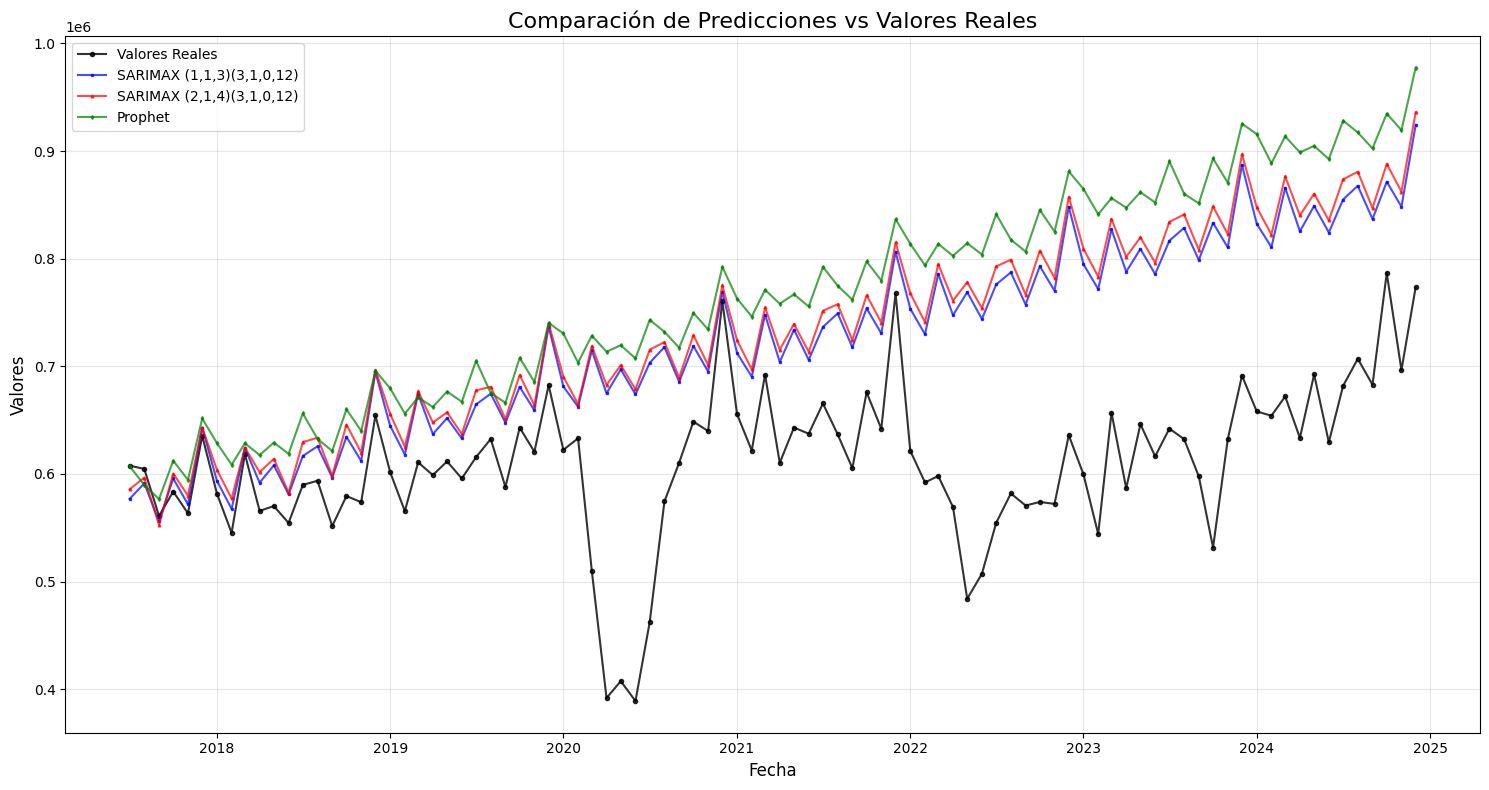

In [162]:

# Crear fechas para el eje X (asumiendo que son consecutivas)
if hasattr(ts_consumo_superior_test, 'index'):
    fechas_test = ts_consumo_superior_test.index
else:
    # Crear fechas genéricas si no están disponibles
    fechas_test = pd.date_range(start='2024-01-01', periods=len(y_test), freq='M')

# Gráfico 1: Comparación de series
plt.figure(figsize=(15, 8))
plt.plot(fechas_test, y_test, 'o-', label='Valores Reales', color='black', markersize=3, alpha=0.8)
plt.plot(fechas_test, pred_113_cs, 's-', label='SARIMAX (1,1,3)(3,1,0,12)', color='blue', markersize=2, alpha=0.7)
plt.plot(fechas_test, pred_214_cs, '^-', label='SARIMAX (2,1,4)(3,1,0,12)', color='red', markersize=2, alpha=0.7)
plt.plot(fechas_test, pred_prophet_cs, 'd-', label='Prophet', color='green', markersize=2, alpha=0.7)

plt.title('Comparación de Predicciones vs Valores Reales', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### <span style="color: blue;">2. Importaciones Gasolina Superior</span>

#### Predicciones

In [ ]:
# Predicciones modelo 112
pred_112_is = resultado_m112_IS.forecast(steps=87)
pred_112_is_ci = resultado_m112_IS.get_forecast(steps=87).conf_int()

# Predicciones modelo 214
pred_214_is = resultado_m214_IS.forecast(steps=87)
pred_214_is_ci = resultado_m214_IS.get_forecast(steps=87).conf_int()

# Crear fechas futuras para Prophet 
futuro_prophet_is = modelo_prophet_is.make_future_dataframe(periods=87, freq='M')
forecast_prophet_is = modelo_prophet_is.predict(futuro_prophet_is)

# Extraer solo las predicciones futuras (últimas 90)
pred_prophet_is = forecast_prophet_is['yhat'].tail(87).values
pred_prophet_bajo_is = forecast_prophet_is['yhat_lower'].tail(87).values
pred_prophet_alto_is = forecast_prophet_is['yhat_upper'].tail(87).values

/Users/arielamishaancohen/Library/Python/3.13/lib/python/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


#### Métricas

In [172]:
y_test_is = ts_importa_superior_test.values if hasattr(ts_importa_superior_test, 'values') else ts_importa_superior_test

# Calcular métricas para cada modelo
metricas_112_is = calcular_metricas(y_test_is, pred_112_is, 'SARIMAX (1,1,2)')
metricas_214_is = calcular_metricas(y_test_is, pred_214_is, 'SARIMAX (2,1,4)')
metricas_prophet_is = calcular_metricas(y_test_is, pred_prophet_is, 'Prophet')

# Crear DataFrame con todas las métricas
df_metricas_is = pd.DataFrame([metricas_112_is, metricas_214_is, metricas_prophet_is])

print(df_metricas_is)

            Modelo        R²           RMSE           MAE       MAPE  \
0  SARIMAX (1,1,2) -0.074643  135066.329718  93522.901295  16.470313   
1  SARIMAX (2,1,4) -0.077038  135216.795215  93592.500889  16.485071   
2          Prophet -0.017535  131428.585859  93450.186478  17.747613   

           BIAS      STD_ERROR           MSE  
0 -38527.226913  129454.880981  1.824291e+10  
1 -38338.052850  129667.942885  1.828358e+10  
2  21402.191055  129674.281949  1.727347e+10  


#### Gráfica

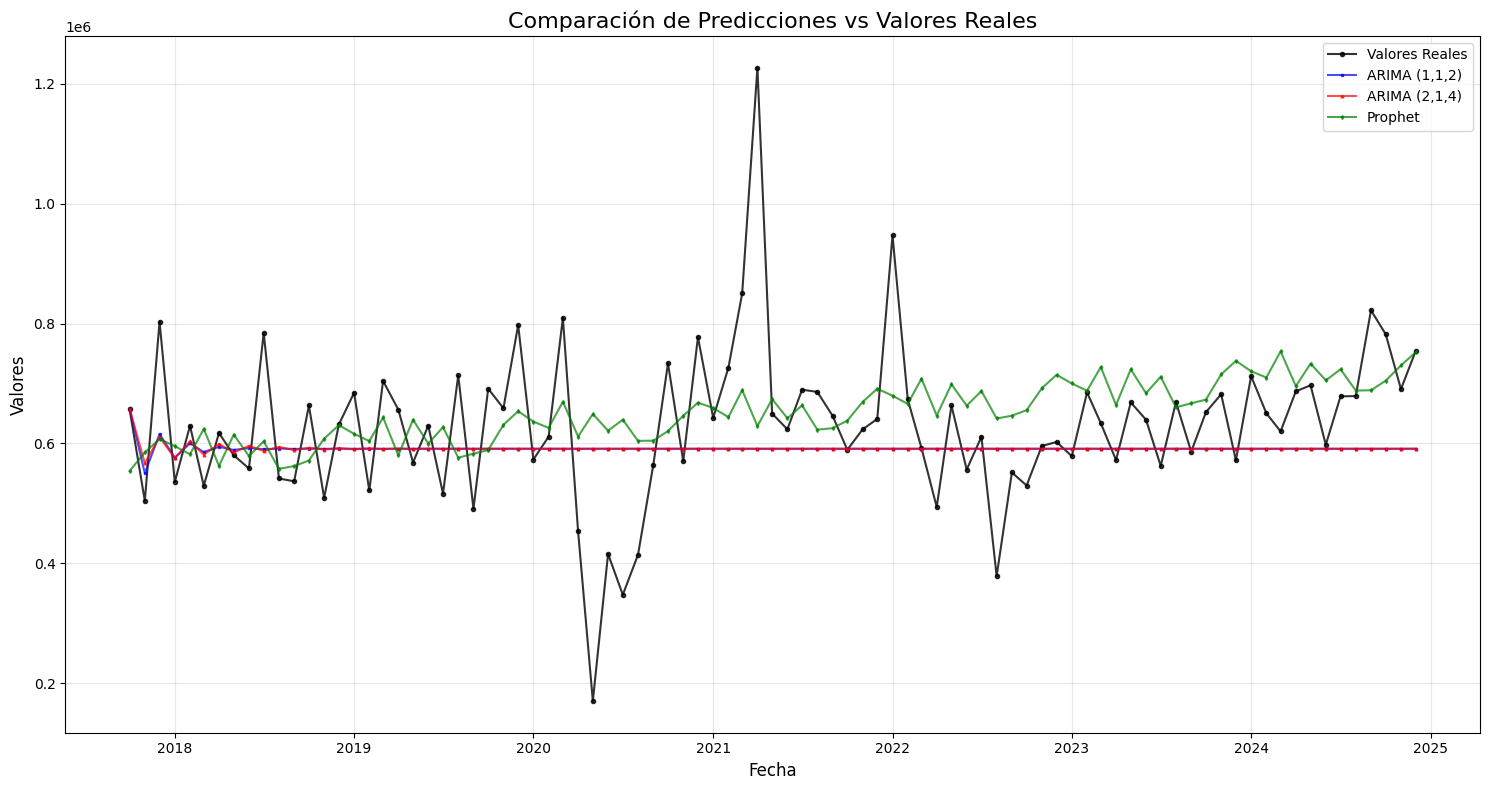

In [185]:
# Crear fechas para el eje X (asumiendo que son consecutivas)
if hasattr(ts_importa_superior_test, 'index'):
    fechas_test_is = ts_importa_superior_test.index
else:
    # Crear fechas genéricas si no están disponibles
    fechas_test_is = pd.date_range(start='2024-01-01', periods=len(y_test_is), freq='M')

# Gráfico 1: Comparación de series
plt.figure(figsize=(15, 8))
plt.plot(fechas_test_is, y_test_is, 'o-', label='Valores Reales', color='black', markersize=3, alpha=0.8)
plt.plot(fechas_test_is, pred_112_is, 's-', label='ARIMA (1,1,2)', color='blue', markersize=2, alpha=0.7)
plt.plot(fechas_test_is, pred_214_is, '^-', label='ARIMA (2,1,4)', color='red', markersize=2, alpha=0.7)
plt.plot(fechas_test_is, pred_prophet_is, 'd-', label='Prophet', color='green', markersize=2, alpha=0.7)

plt.title('Comparación de Predicciones vs Valores Reales', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Aunque en los modelos de ARIMA muestran un mejor valor de **MAPE**, se puede ver en la gráfica que el modelo de Prophet es el único que logra predecir bien la variabilidad de los datos. Por esta razón, se utilizará el modelo **PROPHET IS** para predecir los datos de importaciones de la gasolina superior de 2025.

### <span style="color: blue;">3. Consumo Gasolina Regular</span>

#### Predicciones

#### Métricas

#### Gráfica

### <span style="color: blue;">4.  Importaciones Gasolina Regular</span>

#### Predicciones

#### Métricas

#### Gráfica

### <span style="color: blue;">5. Consumo Diesel</span>

#### Predicciones

#### Métricas

#### Gráfica

### <span style="color: blue;">6. Importaciones Diesel</span>

#### Predicciones

#### Métricas

#### Gráfica